In [1]:
import tensorflow as tf
import os
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.mixed_precision import set_global_policy

In [2]:
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = (64, 64)
INPUT_SHAPE = (64, 64, 3)
EPOCHS = 100
BASE_LEARNING_RATE = 1e-3

In [3]:
# Define the improved model

def build_deepfake_model(input_shape=INPUT_SHAPE):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=True)
    x = layers.GlobalAveragePooling2D()(x)

    # Add fully connected layers with dropout and batch normalization
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=BASE_LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_deepfake_model()
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 efficientnetb0 (Functional)  (None, 2, 2, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0     

In [5]:
import cv2
import numpy as np
import tensorflow as tf
from typing import Tuple

def extract_faces(video_path: str) -> list:
    """Extract faces from video using frame sampling.
    
    Args:
        video_path: Path to input video
        
    Returns:
        List of detected face images (BGR format)
    """
    cap = cv2.VideoCapture(video_path)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = []
    
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = 1
    frame_count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        if frame_count % frame_interval == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            detected_faces = face_cascade.detectMultiScale(
                gray, 
                scaleFactor=1.1, 
                minNeighbors=5,
                minSize=(100, 100)
            )
            
            for (x, y, w, h) in detected_faces:
                face_img = frame[y:y+h, x:x+w]
                faces.append(face_img)
                
        frame_count += 1
    
    cap.release()
    return faces

def preprocess_face(face_img: np.ndarray, target_size: Tuple[int, int] = (64, 64)) -> np.ndarray:
    """Preprocess face image for model input.
    
    Args:
        face_img: BGR image from OpenCV
        target_size: Model input size
        
    Returns:
        Preprocessed RGB image normalized to [0, 1]
    """
    rgb_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    resized_img = cv2.resize(rgb_img, target_size)
    return resized_img.astype(np.float32) / 255.0

def predict_video(video_path: str, model: tf.keras.Model, threshold: float = 0.5) -> Tuple[bool, float]:
    """Main prediction function for deepfake detection.
    
    Args:
        video_path: Path to input video
        model: Loaded Keras model
        threshold: Classification threshold
        
    Returns:
        Tuple of (is_deepfake, mean_probability)
    """
    # Extract and preprocess faces
    faces = extract_faces(video_path)
    if not faces:
        raise ValueError("No faces detected in video")
    
    processed_faces = [preprocess_face(face) for face in faces]
    batch = np.array(processed_faces)
    
    # Make predictions
    predictions = model.predict(batch, verbose=0)
    mean_prob = float(np.mean(predictions))
    
    return mean_prob > threshold, mean_prob
    

In [6]:
# Step 3: Make predictions on the frames
model = build_deepfake_model()  # Replace with your model creation function
# Load the saved weights
model.load_weights('Models/Eb0_OVS3_best_model_weights.h5')

# Make prediction
video_path = './data/Celeb-synthesis/id0_id16_0000.mp4'
is_deepfake, probability = predict_video(video_path, model)

print(f"Deepfake detected: {is_deepfake}")
print(f"Mean probability: {probability:.4f}")
print(f"Classification threshold: {0.5}")

Deepfake detected: True
Mean probability: 0.8280
Classification threshold: 0.5


In [6]:
import os
from typing import Tuple, Dict, List

def predict_directory(video_dir: str, 
                     model: tf.keras.Model, 
                     threshold: float = 0.5,
                     video_extensions: tuple = ('.mp4', '.avi', '.mov', '.mkv')) -> Tuple[Dict[str, int], List[Dict]]:
    """
    Predict deepfake status for all videos in a directory and count results.
    
    Args:
        video_dir: Path to directory containing videos
        model: Loaded Keras model
        threshold: Classification threshold
        video_extensions: Tuple of valid video extensions to process
        
    Returns:
        Tuple containing:
        - Dictionary with counts
        - List of individual video results
    """
    counts = {
        'total_videos': 0,
        'real': 0,
        'fake': 0,
        'errors': 0
    }
    predicted_real=[]
    predicted_fake=[]
    results = []

    # Recursively find all video files
    for root, _, files in os.walk(video_dir):
        for file in files:
            if file.lower().endswith(video_extensions):
                counts['total_videos'] += 1
                video_path = os.path.join(root, file)
                
                try:
                    is_deepfake, prob = predict_video(video_path, model, threshold)
                    result = {
                        'path': video_path,
                        'is_deepfake': is_deepfake,
                        'probability': float(prob),
                        'error': None
                    }
                    
                    if is_deepfake:
                        counts['fake'] += 1
                        predicted_fake.append(video_path)
                        
                    else:
                        counts['real'] += 1
                        predicted_real.append(video_path)
                        
                except Exception as e:
                    counts['errors'] += 1
                    result = {
                        'path': video_path,
                        'error': str(e),
                        'is_deepfake': None,
                        'probability': None
                    }
                
                results.append(result)

    # Print summary
    print("\nPrediction Summary:")
    print(f"Total Videos Processed: {counts['total_videos']}")
    print(f"Real Videos Detected: {counts['real']}")
    print(f"Deepfake Videos Detected: {counts['fake']}")
    print(f"Errors Encountered: {counts['errors']}")
    
    return counts, results,predicted_real,predicted_fake

    
    

In [7]:
import os
from typing import Tuple, Dict, List
from tqdm import tqdm
import tensorflow as tf

def predict_directory(video_dir: str, 
                     model: tf.keras.Model, 
                     threshold: float = 0.5,
                     video_extensions: tuple = ('.mp4', '.avi', '.mov', '.mkv')) -> Tuple[Dict[str, int], List[Dict], List[str], List[str]]:
    """
    Predict deepfake status for all videos in a directory and count results.
    
    Args:
        video_dir: Path to directory containing videos
        model: Loaded Keras model
        threshold: Classification threshold
        video_extensions: Tuple of valid video extensions to process
        
    Returns:
        Tuple containing:
        - Dictionary with counts
        - List of individual video results
        - List of paths predicted as real
        - List of paths predicted as fake
    """
    counts = {
        'total_videos': 0,
        'real': 0,
        'fake': 0,
        'errors': 0
    }
    predicted_real = []
    predicted_fake = []
    results = []
    less_fake=[]
    less_real=[]

    # Collect all video files first for accurate progress tracking
    video_paths = []
    for root, _, files in os.walk(video_dir):
        for file in files:
            if file.lower().endswith(video_extensions):
                video_path = os.path.join(root, file)
                video_paths.append(video_path)
    counts['total_videos'] = len(video_paths)

    # Process videos with progress bar
    for video_path in tqdm(video_paths, desc="Analyzing Videos"):
        try:
            is_deepfake, prob = predict_video(video_path, model, threshold)
            result = {
                'path': video_path,
                'is_deepfake': is_deepfake,
                'probability': float(prob),
                'error': None
            }
            
            if is_deepfake:
                counts['fake'] += 1
                if prob < 0.70:
                    less_fake.append(video_path)
                predicted_fake.append(video_path)
                tqdm.write(f"Fake: {os.path.basename(video_path)} (Confidence: {prob:.2f})")
            else:
                counts['real'] += 1
                if prob > 0.30:
                    less_real.append(video_path)
                predicted_real.append(video_path)
                tqdm.write(f"Real: {os.path.basename(video_path)} (Confidence: {prob:.2f})")
                
        except Exception as e:
            counts['errors'] += 1
            result = {
                'path': video_path,
                'error': str(e),
                'is_deepfake': None,
                'probability': None
            }
            tqdm.write(f"Error: {os.path.basename(video_path)} - {str(e)}")
        
        results.append(result)

    # Final summary
    print("\nPrediction Summary:")
    print(f"Total Videos Processed: {counts['total_videos']}")
    print(f"Real Videos Detected: {counts['real']}")
    print(f"Deepfake Videos Detected: {counts['fake']}")
    print(f"Errors Encountered: {counts['errors']}")
    
    return counts, results, predicted_real, predicted_fake,less_fake,less_real

In [6]:
# Analyze directory
video_directory = "./data/YouTube-real"
counts, detailed_results,real_list,fake_list,less_fake,less_real = predict_directory(video_directory, model)

# Access results
print(f"\nFinal Counts:")
print(f"Real: {counts['real']}")
print(f"Fake: {counts['fake']}")
print(f"Success Rate: {(counts['real'] + counts['fake'])/counts['total_videos']:.2%}")

NameError: name 'predict_directory' is not defined

In [13]:
len(less_real)

116

In [15]:
# Analyze directory
video_directory = "./data/Celeb-real"
counts, detailed_results,real_list,fake_list,less_fake,less_real= predict_directory(video_directory, model)

# Access results
print(f"\nFinal Counts:")
print(f"Real: {counts['real']}")
print(f"Fake: {counts['fake']}")
print(f"Success Rate: {(counts['real'] + counts['fake'])/counts['total_videos']:.2%}")

Analyzing Videos:   0%|▏                                                             | 1/463 [00:09<1:14:03,  9.62s/it]

Real: id0_0000.mp4 (Confidence: 0.44)


Analyzing Videos:   0%|▎                                                               | 2/463 [00:14<53:21,  6.95s/it]

Real: id0_0001.mp4 (Confidence: 0.38)


Analyzing Videos:   1%|▍                                                             | 3/463 [00:23<1:00:30,  7.89s/it]

Fake: id0_0003.mp4 (Confidence: 0.50)


Analyzing Videos:   1%|▌                                                               | 4/463 [00:30<58:24,  7.63s/it]

Real: id0_0004.mp4 (Confidence: 0.34)


Analyzing Videos:   1%|▋                                                               | 5/463 [00:37<55:43,  7.30s/it]

Real: id0_0005.mp4 (Confidence: 0.41)


Analyzing Videos:   1%|▊                                                             | 6/463 [00:50<1:09:00,  9.06s/it]

Real: id0_0006.mp4 (Confidence: 0.36)


Analyzing Videos:   2%|▉                                                             | 7/463 [01:01<1:14:43,  9.83s/it]

Real: id0_0007.mp4 (Confidence: 0.37)


Analyzing Videos:   2%|█                                                             | 8/463 [01:10<1:13:34,  9.70s/it]

Real: id0_0008.mp4 (Confidence: 0.39)


Analyzing Videos:   2%|█▏                                                            | 9/463 [01:20<1:14:09,  9.80s/it]

Real: id0_0009.mp4 (Confidence: 0.41)


Analyzing Videos:   2%|█▎                                                           | 10/463 [01:25<1:01:40,  8.17s/it]

Real: id10_0000.mp4 (Confidence: 0.35)


Analyzing Videos:   2%|█▍                                                             | 11/463 [01:32<59:45,  7.93s/it]

Real: id10_0002.mp4 (Confidence: 0.32)


Analyzing Videos:   3%|█▋                                                             | 12/463 [01:40<58:56,  7.84s/it]

Real: id10_0003.mp4 (Confidence: 0.47)


Analyzing Videos:   3%|█▋                                                           | 13/463 [01:51<1:06:02,  8.81s/it]

Real: id10_0004.mp4 (Confidence: 0.44)


Analyzing Videos:   3%|█▊                                                           | 14/463 [01:59<1:03:33,  8.49s/it]

Real: id10_0005.mp4 (Confidence: 0.37)


Analyzing Videos:   3%|██                                                             | 15/463 [02:02<52:05,  6.98s/it]

Real: id10_0006.mp4 (Confidence: 0.43)


Analyzing Videos:   3%|██▏                                                            | 16/463 [02:10<53:12,  7.14s/it]

Real: id10_0007.mp4 (Confidence: 0.20)


Analyzing Videos:   4%|██▎                                                            | 17/463 [02:16<50:20,  6.77s/it]

Real: id10_0008.mp4 (Confidence: 0.28)


Analyzing Videos:   4%|██▎                                                          | 18/463 [02:27<1:00:46,  8.20s/it]

Real: id10_0009.mp4 (Confidence: 0.27)


Analyzing Videos:   4%|██▌                                                            | 19/463 [02:34<56:47,  7.68s/it]

Real: id11_0000.mp4 (Confidence: 0.30)


Analyzing Videos:   4%|██▋                                                            | 20/463 [02:41<55:51,  7.57s/it]

Real: id11_0001.mp4 (Confidence: 0.23)


Analyzing Videos:   5%|██▊                                                          | 21/463 [02:52<1:02:28,  8.48s/it]

Real: id11_0002.mp4 (Confidence: 0.38)


Analyzing Videos:   5%|██▉                                                            | 22/463 [02:58<57:29,  7.82s/it]

Real: id11_0003.mp4 (Confidence: 0.36)


Analyzing Videos:   5%|███▏                                                           | 23/463 [03:04<52:50,  7.20s/it]

Real: id11_0004.mp4 (Confidence: 0.37)


Analyzing Videos:   5%|███▎                                                           | 24/463 [03:11<53:09,  7.26s/it]

Real: id11_0005.mp4 (Confidence: 0.26)


Analyzing Videos:   5%|███▍                                                           | 25/463 [03:20<55:34,  7.61s/it]

Real: id11_0006.mp4 (Confidence: 0.30)


Analyzing Videos:   6%|███▌                                                           | 26/463 [03:25<51:36,  7.09s/it]

Real: id11_0007.mp4 (Confidence: 0.45)


Analyzing Videos:   6%|███▋                                                           | 27/463 [03:33<52:15,  7.19s/it]

Real: id11_0008.mp4 (Confidence: 0.43)


Analyzing Videos:   6%|███▊                                                           | 28/463 [03:41<55:11,  7.61s/it]

Real: id11_0009.mp4 (Confidence: 0.23)


Analyzing Videos:   6%|███▉                                                           | 29/463 [03:46<48:54,  6.76s/it]

Real: id11_0010.mp4 (Confidence: 0.25)


Analyzing Videos:   6%|████                                                           | 30/463 [03:53<48:06,  6.67s/it]

Real: id12_0000.mp4 (Confidence: 0.32)


Analyzing Videos:   7%|████▏                                                          | 31/463 [04:00<49:15,  6.84s/it]

Real: id12_0001.mp4 (Confidence: 0.32)


Analyzing Videos:   7%|████▎                                                          | 32/463 [04:04<44:16,  6.16s/it]

Real: id12_0002.mp4 (Confidence: 0.47)


Analyzing Videos:   7%|████▍                                                          | 33/463 [04:13<49:29,  6.91s/it]

Real: id12_0003.mp4 (Confidence: 0.41)


Analyzing Videos:   7%|████▋                                                          | 34/463 [04:19<46:33,  6.51s/it]

Real: id12_0004.mp4 (Confidence: 0.24)


Analyzing Videos:   8%|████▊                                                          | 35/463 [04:24<44:53,  6.29s/it]

Real: id12_0005.mp4 (Confidence: 0.23)


Analyzing Videos:   8%|████▉                                                          | 36/463 [04:31<45:01,  6.33s/it]

Real: id12_0006.mp4 (Confidence: 0.48)


Analyzing Videos:   8%|█████                                                          | 37/463 [04:37<45:33,  6.42s/it]

Fake: id13_0000.mp4 (Confidence: 0.51)


Analyzing Videos:   8%|█████▏                                                         | 38/463 [04:44<46:18,  6.54s/it]

Real: id13_0001.mp4 (Confidence: 0.47)


Analyzing Videos:   8%|█████▎                                                         | 39/463 [04:50<44:21,  6.28s/it]

Real: id13_0002.mp4 (Confidence: 0.41)


Analyzing Videos:   9%|█████▍                                                         | 40/463 [04:55<41:58,  5.95s/it]

Real: id13_0003.mp4 (Confidence: 0.22)


Analyzing Videos:   9%|█████▌                                                         | 41/463 [05:01<42:00,  5.97s/it]

Real: id13_0004.mp4 (Confidence: 0.27)


Analyzing Videos:   9%|█████▋                                                         | 42/463 [05:07<40:42,  5.80s/it]

Real: id13_0005.mp4 (Confidence: 0.32)


Analyzing Videos:   9%|█████▊                                                         | 43/463 [05:15<46:32,  6.65s/it]

Real: id13_0006.mp4 (Confidence: 0.41)


Analyzing Videos:  10%|█████▉                                                         | 44/463 [05:25<53:14,  7.62s/it]

Real: id13_0007.mp4 (Confidence: 0.21)


Analyzing Videos:  10%|██████                                                         | 45/463 [05:33<53:56,  7.74s/it]

Real: id13_0008.mp4 (Confidence: 0.23)


Analyzing Videos:  10%|██████▎                                                        | 46/463 [05:40<52:45,  7.59s/it]

Real: id13_0009.mp4 (Confidence: 0.37)


Analyzing Videos:  10%|██████▍                                                        | 47/463 [05:50<56:14,  8.11s/it]

Real: id13_0010.mp4 (Confidence: 0.44)


Analyzing Videos:  10%|██████▎                                                      | 48/463 [06:01<1:01:50,  8.94s/it]

Real: id13_0011.mp4 (Confidence: 0.25)


Analyzing Videos:  11%|██████▍                                                      | 49/463 [06:10<1:01:58,  8.98s/it]

Real: id13_0012.mp4 (Confidence: 0.23)


Analyzing Videos:  11%|██████▌                                                      | 50/463 [06:19<1:02:47,  9.12s/it]

Real: id13_0013.mp4 (Confidence: 0.49)


Analyzing Videos:  11%|██████▉                                                        | 51/463 [06:26<58:04,  8.46s/it]

Real: id13_0014.mp4 (Confidence: 0.34)


Analyzing Videos:  11%|██████▊                                                      | 52/463 [06:37<1:02:29,  9.12s/it]

Real: id13_0015.mp4 (Confidence: 0.24)


Analyzing Videos:  11%|███████▏                                                       | 53/463 [06:43<56:34,  8.28s/it]

Real: id16_0001.mp4 (Confidence: 0.39)


Analyzing Videos:  12%|███████▎                                                       | 54/463 [06:50<53:55,  7.91s/it]

Real: id16_0002.mp4 (Confidence: 0.42)


Analyzing Videos:  12%|███████▍                                                       | 55/463 [06:57<51:27,  7.57s/it]

Real: id16_0003.mp4 (Confidence: 0.29)


Analyzing Videos:  12%|███████▌                                                       | 56/463 [07:04<51:09,  7.54s/it]

Real: id16_0004.mp4 (Confidence: 0.49)


Analyzing Videos:  12%|███████▊                                                       | 57/463 [07:11<49:03,  7.25s/it]

Real: id16_0005.mp4 (Confidence: 0.26)


Analyzing Videos:  13%|███████▉                                                       | 58/463 [07:17<46:45,  6.93s/it]

Real: id16_0007.mp4 (Confidence: 0.30)


Analyzing Videos:  13%|████████                                                       | 59/463 [07:25<47:42,  7.09s/it]

Real: id16_0009.mp4 (Confidence: 0.34)


Analyzing Videos:  13%|████████▏                                                      | 60/463 [07:31<46:13,  6.88s/it]

Real: id16_0010.mp4 (Confidence: 0.32)


Analyzing Videos:  13%|████████▎                                                      | 61/463 [07:35<41:25,  6.18s/it]

Real: id16_0011.mp4 (Confidence: 0.32)


Analyzing Videos:  13%|████████▍                                                      | 62/463 [07:42<42:51,  6.41s/it]

Real: id16_0012.mp4 (Confidence: 0.32)


Analyzing Videos:  14%|████████▌                                                      | 63/463 [07:49<42:13,  6.33s/it]

Real: id16_0013.mp4 (Confidence: 0.28)


Analyzing Videos:  14%|████████▋                                                      | 64/463 [07:53<38:19,  5.76s/it]

Real: id17_0001.mp4 (Confidence: 0.46)


Analyzing Videos:  14%|████████▊                                                      | 65/463 [08:00<41:05,  6.19s/it]

Real: id17_0005.mp4 (Confidence: 0.46)


Analyzing Videos:  14%|████████▉                                                      | 66/463 [08:07<42:10,  6.37s/it]

Real: id17_0009.mp4 (Confidence: 0.45)


Analyzing Videos:  14%|█████████                                                      | 67/463 [08:12<38:36,  5.85s/it]

Real: id19_0000.mp4 (Confidence: 0.35)


Analyzing Videos:  15%|█████████▎                                                     | 68/463 [08:19<42:01,  6.38s/it]

Real: id19_0001.mp4 (Confidence: 0.39)


Analyzing Videos:  15%|█████████▍                                                     | 69/463 [08:21<33:14,  5.06s/it]

Real: id19_0002.mp4 (Confidence: 0.37)


Analyzing Videos:  15%|█████████▌                                                     | 70/463 [08:27<35:07,  5.36s/it]

Real: id19_0003.mp4 (Confidence: 0.41)


Analyzing Videos:  15%|█████████▋                                                     | 71/463 [08:32<34:18,  5.25s/it]

Real: id19_0004.mp4 (Confidence: 0.28)


Analyzing Videos:  16%|█████████▊                                                     | 72/463 [08:38<35:42,  5.48s/it]

Real: id19_0005.mp4 (Confidence: 0.37)


Analyzing Videos:  16%|█████████▉                                                     | 73/463 [08:43<34:44,  5.34s/it]

Real: id19_0006.mp4 (Confidence: 0.31)


Analyzing Videos:  16%|██████████                                                     | 74/463 [08:50<36:19,  5.60s/it]

Real: id19_0007.mp4 (Confidence: 0.29)


Analyzing Videos:  16%|██████████▏                                                    | 75/463 [08:55<36:14,  5.60s/it]

Real: id19_0008.mp4 (Confidence: 0.30)


Analyzing Videos:  16%|██████████▎                                                    | 76/463 [09:00<34:14,  5.31s/it]

Real: id19_0009.mp4 (Confidence: 0.37)


Analyzing Videos:  17%|██████████▍                                                    | 77/463 [09:05<34:21,  5.34s/it]

Real: id1_0000.mp4 (Confidence: 0.49)


Analyzing Videos:  17%|██████████▌                                                    | 78/463 [09:12<36:52,  5.75s/it]

Real: id1_0003.mp4 (Confidence: 0.46)


Analyzing Videos:  17%|██████████▋                                                    | 79/463 [09:17<36:25,  5.69s/it]

Real: id1_0004.mp4 (Confidence: 0.43)


Analyzing Videos:  17%|██████████▉                                                    | 80/463 [09:24<38:32,  6.04s/it]

Real: id1_0005.mp4 (Confidence: 0.39)


Analyzing Videos:  17%|███████████                                                    | 81/463 [09:31<39:33,  6.21s/it]

Real: id1_0008.mp4 (Confidence: 0.32)


Analyzing Videos:  18%|███████████▏                                                   | 82/463 [09:36<38:10,  6.01s/it]

Real: id20_0003.mp4 (Confidence: 0.48)


Analyzing Videos:  18%|███████████▎                                                   | 83/463 [09:42<36:35,  5.78s/it]

Real: id20_0004.mp4 (Confidence: 0.41)


Analyzing Videos:  18%|███████████▍                                                   | 84/463 [09:48<36:54,  5.84s/it]

Real: id20_0005.mp4 (Confidence: 0.38)


Analyzing Videos:  18%|███████████▌                                                   | 85/463 [09:53<35:38,  5.66s/it]

Real: id20_0006.mp4 (Confidence: 0.39)


Analyzing Videos:  19%|███████████▋                                                   | 86/463 [10:02<41:11,  6.56s/it]

Real: id20_0007.mp4 (Confidence: 0.37)


Analyzing Videos:  19%|███████████▊                                                   | 87/463 [10:10<44:19,  7.07s/it]

Real: id20_0008.mp4 (Confidence: 0.30)


Analyzing Videos:  19%|███████████▉                                                   | 88/463 [10:16<41:44,  6.68s/it]

Real: id21_0000.mp4 (Confidence: 0.45)


Analyzing Videos:  19%|████████████                                                   | 89/463 [10:23<42:39,  6.84s/it]

Real: id21_0001.mp4 (Confidence: 0.46)


Analyzing Videos:  19%|████████████▏                                                  | 90/463 [10:30<42:36,  6.85s/it]

Real: id21_0002.mp4 (Confidence: 0.29)


Analyzing Videos:  20%|████████████▍                                                  | 91/463 [10:35<38:43,  6.25s/it]

Real: id21_0003.mp4 (Confidence: 0.26)


Analyzing Videos:  20%|████████████▌                                                  | 92/463 [10:38<34:05,  5.51s/it]

Real: id21_0005.mp4 (Confidence: 0.43)


Analyzing Videos:  20%|████████████▋                                                  | 93/463 [10:45<35:58,  5.83s/it]

Real: id21_0006.mp4 (Confidence: 0.36)


Analyzing Videos:  20%|████████████▊                                                  | 94/463 [10:52<37:36,  6.11s/it]

Real: id21_0007.mp4 (Confidence: 0.32)


Analyzing Videos:  21%|████████████▉                                                  | 95/463 [10:57<35:51,  5.85s/it]

Real: id21_0008.mp4 (Confidence: 0.35)


Analyzing Videos:  21%|█████████████                                                  | 96/463 [11:02<34:38,  5.66s/it]

Real: id21_0009.mp4 (Confidence: 0.42)


Analyzing Videos:  21%|█████████████▏                                                 | 97/463 [11:05<29:18,  4.80s/it]

Real: id22_0000.mp4 (Confidence: 0.33)


Analyzing Videos:  21%|█████████████▎                                                 | 98/463 [11:10<29:32,  4.86s/it]

Real: id22_0001.mp4 (Confidence: 0.38)


Analyzing Videos:  21%|█████████████▍                                                 | 99/463 [11:15<29:38,  4.89s/it]

Real: id22_0003.mp4 (Confidence: 0.41)


Analyzing Videos:  22%|█████████████▍                                                | 100/463 [11:21<31:26,  5.20s/it]

Real: id22_0005.mp4 (Confidence: 0.37)


Analyzing Videos:  22%|█████████████▌                                                | 101/463 [11:26<32:05,  5.32s/it]

Real: id22_0006.mp4 (Confidence: 0.45)


Analyzing Videos:  22%|█████████████▋                                                | 102/463 [11:32<32:51,  5.46s/it]

Real: id22_0007.mp4 (Confidence: 0.43)


Analyzing Videos:  22%|█████████████▊                                                | 103/463 [11:39<35:36,  5.93s/it]

Real: id22_0008.mp4 (Confidence: 0.28)


Analyzing Videos:  22%|█████████████▉                                                | 104/463 [11:43<31:41,  5.30s/it]

Real: id23_0000.mp4 (Confidence: 0.32)


Analyzing Videos:  23%|██████████████                                                | 105/463 [11:47<29:31,  4.95s/it]

Real: id23_0003.mp4 (Confidence: 0.44)


Analyzing Videos:  23%|██████████████▏                                               | 106/463 [11:52<28:52,  4.85s/it]

Real: id23_0006.mp4 (Confidence: 0.28)


Analyzing Videos:  23%|██████████████▎                                               | 107/463 [12:00<34:58,  5.89s/it]

Real: id23_0009.mp4 (Confidence: 0.40)


Analyzing Videos:  23%|██████████████▍                                               | 108/463 [12:05<32:34,  5.51s/it]

Real: id24_0001.mp4 (Confidence: 0.24)


Analyzing Videos:  24%|██████████████▌                                               | 109/463 [12:09<30:28,  5.17s/it]

Real: id24_0002.mp4 (Confidence: 0.21)


Analyzing Videos:  24%|██████████████▋                                               | 110/463 [12:11<24:40,  4.20s/it]

Real: id24_0003.mp4 (Confidence: 0.40)


Analyzing Videos:  24%|██████████████▊                                               | 111/463 [12:16<25:30,  4.35s/it]

Real: id24_0004.mp4 (Confidence: 0.36)


Analyzing Videos:  24%|██████████████▉                                               | 112/463 [12:22<28:01,  4.79s/it]

Real: id24_0005.mp4 (Confidence: 0.39)


Analyzing Videos:  24%|███████████████▏                                              | 113/463 [12:28<30:24,  5.21s/it]

Real: id24_0006.mp4 (Confidence: 0.28)


Analyzing Videos:  25%|███████████████▎                                              | 114/463 [12:34<31:34,  5.43s/it]

Real: id24_0007.mp4 (Confidence: 0.33)


Analyzing Videos:  25%|███████████████▍                                              | 115/463 [12:40<32:20,  5.58s/it]

Real: id24_0008.mp4 (Confidence: 0.38)


Analyzing Videos:  25%|███████████████▌                                              | 116/463 [12:45<32:44,  5.66s/it]

Real: id24_0009.mp4 (Confidence: 0.28)


Analyzing Videos:  25%|███████████████▋                                              | 117/463 [12:49<29:21,  5.09s/it]

Real: id25_0000.mp4 (Confidence: 0.42)


Analyzing Videos:  25%|███████████████▊                                              | 118/463 [12:56<32:27,  5.65s/it]

Real: id25_0001.mp4 (Confidence: 0.43)


Analyzing Videos:  26%|███████████████▉                                              | 119/463 [13:02<33:15,  5.80s/it]

Real: id25_0002.mp4 (Confidence: 0.42)


Analyzing Videos:  26%|████████████████                                              | 120/463 [13:07<31:41,  5.54s/it]

Real: id25_0003.mp4 (Confidence: 0.46)


Analyzing Videos:  26%|████████████████▏                                             | 121/463 [13:13<31:28,  5.52s/it]

Real: id25_0004.mp4 (Confidence: 0.45)


Analyzing Videos:  26%|████████████████▎                                             | 122/463 [13:18<31:29,  5.54s/it]

Real: id25_0006.mp4 (Confidence: 0.19)


Analyzing Videos:  27%|████████████████▍                                             | 123/463 [13:25<32:55,  5.81s/it]

Real: id25_0007.mp4 (Confidence: 0.29)


Analyzing Videos:  27%|████████████████▌                                             | 124/463 [13:29<30:45,  5.44s/it]

Real: id25_0008.mp4 (Confidence: 0.44)


Analyzing Videos:  27%|████████████████▋                                             | 125/463 [13:34<29:36,  5.26s/it]

Real: id25_0009.mp4 (Confidence: 0.28)


Analyzing Videos:  27%|████████████████▊                                             | 126/463 [13:38<27:01,  4.81s/it]

Real: id26_0000.mp4 (Confidence: 0.31)


Analyzing Videos:  27%|█████████████████                                             | 127/463 [13:41<23:49,  4.25s/it]

Real: id26_0003.mp4 (Confidence: 0.27)


Analyzing Videos:  28%|█████████████████▏                                            | 128/463 [13:46<25:53,  4.64s/it]

Real: id26_0004.mp4 (Confidence: 0.20)


Analyzing Videos:  28%|█████████████████▎                                            | 129/463 [13:51<26:06,  4.69s/it]

Real: id26_0005.mp4 (Confidence: 0.26)


Analyzing Videos:  28%|█████████████████▍                                            | 130/463 [13:57<27:31,  4.96s/it]

Real: id26_0006.mp4 (Confidence: 0.26)


Analyzing Videos:  28%|█████████████████▌                                            | 131/463 [14:04<31:38,  5.72s/it]

Real: id26_0007.mp4 (Confidence: 0.49)


Analyzing Videos:  29%|█████████████████▋                                            | 132/463 [14:10<31:55,  5.79s/it]

Fake: id26_0008.mp4 (Confidence: 0.51)


Analyzing Videos:  29%|█████████████████▊                                            | 133/463 [14:17<32:53,  5.98s/it]

Real: id26_0009.mp4 (Confidence: 0.29)


Analyzing Videos:  29%|█████████████████▉                                            | 134/463 [14:21<29:27,  5.37s/it]

Real: id27_0000.mp4 (Confidence: 0.26)


Analyzing Videos:  29%|██████████████████                                            | 135/463 [14:25<27:32,  5.04s/it]

Real: id27_0001.mp4 (Confidence: 0.19)


Analyzing Videos:  29%|██████████████████▏                                           | 136/463 [14:31<28:46,  5.28s/it]

Real: id27_0002.mp4 (Confidence: 0.35)


Analyzing Videos:  30%|██████████████████▎                                           | 137/463 [14:36<27:50,  5.12s/it]

Real: id27_0003.mp4 (Confidence: 0.46)
Error: id27_0005.mp4 - No faces detected in video


Analyzing Videos:  30%|██████████████████▌                                           | 139/463 [14:40<20:54,  3.87s/it]

Real: id27_0006.mp4 (Confidence: 0.38)


Analyzing Videos:  30%|██████████████████▋                                           | 140/463 [14:44<21:02,  3.91s/it]

Real: id27_0007.mp4 (Confidence: 0.34)


Analyzing Videos:  30%|██████████████████▉                                           | 141/463 [14:49<22:31,  4.20s/it]

Real: id27_0008.mp4 (Confidence: 0.23)


Analyzing Videos:  31%|███████████████████                                           | 142/463 [14:54<23:38,  4.42s/it]

Real: id27_0009.mp4 (Confidence: 0.40)


Analyzing Videos:  31%|███████████████████▏                                          | 143/463 [15:02<28:04,  5.26s/it]

Real: id28_0003.mp4 (Confidence: 0.36)


Analyzing Videos:  31%|███████████████████▎                                          | 144/463 [15:08<30:02,  5.65s/it]

Real: id28_0005.mp4 (Confidence: 0.41)


Analyzing Videos:  31%|███████████████████▍                                          | 145/463 [15:14<30:30,  5.76s/it]

Real: id28_0009.mp4 (Confidence: 0.42)


Analyzing Videos:  32%|███████████████████▌                                          | 146/463 [15:20<29:58,  5.67s/it]

Real: id29_0001.mp4 (Confidence: 0.30)


Analyzing Videos:  32%|███████████████████▋                                          | 147/463 [15:28<33:06,  6.29s/it]

Real: id29_0002.mp4 (Confidence: 0.36)


Analyzing Videos:  32%|███████████████████▊                                          | 148/463 [15:34<32:57,  6.28s/it]

Real: id29_0003.mp4 (Confidence: 0.33)


Analyzing Videos:  32%|███████████████████▉                                          | 149/463 [15:42<36:02,  6.89s/it]

Real: id29_0008.mp4 (Confidence: 0.41)


Analyzing Videos:  32%|████████████████████                                          | 150/463 [15:49<36:07,  6.93s/it]

Real: id29_0009.mp4 (Confidence: 0.27)


Analyzing Videos:  33%|████████████████████▏                                         | 151/463 [15:56<35:28,  6.82s/it]

Real: id2_0000.mp4 (Confidence: 0.28)


Analyzing Videos:  33%|████████████████████▎                                         | 152/463 [16:02<34:21,  6.63s/it]

Real: id2_0001.mp4 (Confidence: 0.45)


Analyzing Videos:  33%|████████████████████▍                                         | 153/463 [16:08<33:51,  6.55s/it]

Real: id2_0002.mp4 (Confidence: 0.35)


Analyzing Videos:  33%|████████████████████▌                                         | 154/463 [16:16<35:28,  6.89s/it]

Real: id2_0004.mp4 (Confidence: 0.42)


Analyzing Videos:  33%|████████████████████▊                                         | 155/463 [16:21<32:01,  6.24s/it]

Real: id2_0005.mp4 (Confidence: 0.41)


Analyzing Videos:  34%|████████████████████▉                                         | 156/463 [16:31<38:34,  7.54s/it]

Real: id30_0000.mp4 (Confidence: 0.44)


Analyzing Videos:  34%|█████████████████████                                         | 157/463 [16:43<44:36,  8.75s/it]

Real: id30_0001.mp4 (Confidence: 0.37)


Analyzing Videos:  34%|█████████████████████▏                                        | 158/463 [16:52<45:43,  8.99s/it]

Real: id30_0002.mp4 (Confidence: 0.38)


Analyzing Videos:  34%|█████████████████████▎                                        | 159/463 [17:02<45:41,  9.02s/it]

Real: id30_0003.mp4 (Confidence: 0.40)


Analyzing Videos:  35%|█████████████████████▍                                        | 160/463 [17:08<40:57,  8.11s/it]

Real: id30_0004.mp4 (Confidence: 0.35)


Analyzing Videos:  35%|█████████████████████▌                                        | 161/463 [17:17<42:14,  8.39s/it]

Real: id30_0005.mp4 (Confidence: 0.38)


Analyzing Videos:  35%|█████████████████████▋                                        | 162/463 [17:22<38:07,  7.60s/it]

Real: id30_0006.mp4 (Confidence: 0.33)


Analyzing Videos:  35%|█████████████████████▊                                        | 163/463 [17:29<36:21,  7.27s/it]

Real: id30_0007.mp4 (Confidence: 0.36)


Analyzing Videos:  35%|█████████████████████▉                                        | 164/463 [17:38<39:34,  7.94s/it]

Real: id30_0008.mp4 (Confidence: 0.24)


Analyzing Videos:  36%|██████████████████████                                        | 165/463 [17:50<45:26,  9.15s/it]

Real: id30_0009.mp4 (Confidence: 0.47)


Analyzing Videos:  36%|██████████████████████▏                                       | 166/463 [17:59<45:04,  9.11s/it]

Real: id31_0004.mp4 (Confidence: 0.40)


Analyzing Videos:  36%|██████████████████████▎                                       | 167/463 [18:06<41:47,  8.47s/it]

Real: id31_0008.mp4 (Confidence: 0.35)


Analyzing Videos:  36%|██████████████████████▍                                       | 168/463 [18:14<40:11,  8.17s/it]

Real: id32_0003.mp4 (Confidence: 0.45)


Analyzing Videos:  37%|██████████████████████▋                                       | 169/463 [18:20<36:27,  7.44s/it]

Real: id32_0004.mp4 (Confidence: 0.33)


Analyzing Videos:  37%|██████████████████████▊                                       | 170/463 [18:27<36:58,  7.57s/it]

Real: id32_0007.mp4 (Confidence: 0.49)


Analyzing Videos:  37%|██████████████████████▉                                       | 171/463 [18:35<37:09,  7.63s/it]

Real: id32_0009.mp4 (Confidence: 0.26)


Analyzing Videos:  37%|███████████████████████                                       | 172/463 [18:42<35:49,  7.39s/it]

Real: id33_0000.mp4 (Confidence: 0.38)


Analyzing Videos:  37%|███████████████████████▏                                      | 173/463 [18:50<36:00,  7.45s/it]

Fake: id33_0001.mp4 (Confidence: 0.52)


Analyzing Videos:  38%|███████████████████████▎                                      | 174/463 [18:56<34:24,  7.14s/it]

Real: id33_0002.mp4 (Confidence: 0.37)


Analyzing Videos:  38%|███████████████████████▍                                      | 175/463 [19:06<38:44,  8.07s/it]

Real: id33_0003.mp4 (Confidence: 0.41)


Analyzing Videos:  38%|███████████████████████▌                                      | 176/463 [19:12<34:44,  7.26s/it]

Real: id33_0004.mp4 (Confidence: 0.34)


Analyzing Videos:  38%|███████████████████████▋                                      | 177/463 [19:18<33:16,  6.98s/it]

Real: id33_0006.mp4 (Confidence: 0.48)


Analyzing Videos:  38%|███████████████████████▊                                      | 178/463 [19:25<33:55,  7.14s/it]

Real: id33_0007.mp4 (Confidence: 0.45)


Analyzing Videos:  39%|███████████████████████▉                                      | 179/463 [19:32<32:17,  6.82s/it]

Real: id34_0000.mp4 (Confidence: 0.43)


Analyzing Videos:  39%|████████████████████████                                      | 180/463 [19:38<31:43,  6.73s/it]

Real: id34_0001.mp4 (Confidence: 0.43)


Analyzing Videos:  39%|████████████████████████▏                                     | 181/463 [19:44<30:02,  6.39s/it]

Real: id34_0002.mp4 (Confidence: 0.41)


Analyzing Videos:  39%|████████████████████████▎                                     | 182/463 [19:49<27:44,  5.92s/it]

Real: id34_0003.mp4 (Confidence: 0.44)


Analyzing Videos:  40%|████████████████████████▌                                     | 183/463 [19:55<28:57,  6.21s/it]

Real: id34_0004.mp4 (Confidence: 0.35)


Analyzing Videos:  40%|████████████████████████▋                                     | 184/463 [20:04<31:42,  6.82s/it]

Fake: id34_0005.mp4 (Confidence: 0.50)


Analyzing Videos:  40%|████████████████████████▊                                     | 185/463 [20:11<32:04,  6.92s/it]

Real: id34_0006.mp4 (Confidence: 0.40)


Analyzing Videos:  40%|████████████████████████▉                                     | 186/463 [20:18<31:45,  6.88s/it]

Real: id34_0007.mp4 (Confidence: 0.49)


Analyzing Videos:  40%|█████████████████████████                                     | 187/463 [20:24<31:26,  6.83s/it]

Real: id34_0008.mp4 (Confidence: 0.42)


Analyzing Videos:  41%|█████████████████████████▏                                    | 188/463 [20:34<34:50,  7.60s/it]

Fake: id34_0009.mp4 (Confidence: 0.50)


Analyzing Videos:  41%|█████████████████████████▎                                    | 189/463 [20:42<35:34,  7.79s/it]

Real: id35_0000.mp4 (Confidence: 0.35)


Analyzing Videos:  41%|█████████████████████████▍                                    | 190/463 [20:48<33:11,  7.30s/it]

Real: id35_0002.mp4 (Confidence: 0.43)


Analyzing Videos:  41%|█████████████████████████▌                                    | 191/463 [20:57<35:28,  7.83s/it]

Real: id35_0003.mp4 (Confidence: 0.46)


Analyzing Videos:  41%|█████████████████████████▋                                    | 192/463 [21:02<31:06,  6.89s/it]

Real: id35_0004.mp4 (Confidence: 0.36)


Analyzing Videos:  42%|█████████████████████████▊                                    | 193/463 [21:10<32:36,  7.25s/it]

Real: id35_0007.mp4 (Confidence: 0.49)


Analyzing Videos:  42%|█████████████████████████▉                                    | 194/463 [21:13<27:26,  6.12s/it]

Real: id35_0009.mp4 (Confidence: 0.42)


Analyzing Videos:  42%|██████████████████████████                                    | 195/463 [21:22<30:36,  6.85s/it]

Real: id36_0000.mp4 (Confidence: 0.24)


Analyzing Videos:  42%|██████████████████████████▏                                   | 196/463 [21:27<28:00,  6.29s/it]

Real: id36_0001.mp4 (Confidence: 0.18)


Analyzing Videos:  43%|██████████████████████████▍                                   | 197/463 [21:35<29:57,  6.76s/it]

Real: id36_0002.mp4 (Confidence: 0.28)


Analyzing Videos:  43%|██████████████████████████▌                                   | 198/463 [21:42<31:00,  7.02s/it]

Real: id36_0003.mp4 (Confidence: 0.17)


Analyzing Videos:  43%|██████████████████████████▋                                   | 199/463 [21:49<30:08,  6.85s/it]

Real: id36_0004.mp4 (Confidence: 0.28)


Analyzing Videos:  43%|██████████████████████████▊                                   | 200/463 [21:55<29:12,  6.66s/it]

Real: id36_0005.mp4 (Confidence: 0.25)


Analyzing Videos:  43%|██████████████████████████▉                                   | 201/463 [22:04<31:40,  7.25s/it]

Real: id36_0006.mp4 (Confidence: 0.23)


Analyzing Videos:  44%|███████████████████████████                                   | 202/463 [22:12<33:04,  7.60s/it]

Real: id36_0007.mp4 (Confidence: 0.20)


Analyzing Videos:  44%|███████████████████████████▏                                  | 203/463 [22:18<30:49,  7.11s/it]

Real: id36_0008.mp4 (Confidence: 0.17)


Analyzing Videos:  44%|███████████████████████████▎                                  | 204/463 [22:23<27:51,  6.45s/it]

Real: id36_0009.mp4 (Confidence: 0.26)


Analyzing Videos:  44%|███████████████████████████▍                                  | 205/463 [22:32<31:29,  7.32s/it]

Real: id37_0000.mp4 (Confidence: 0.35)


Analyzing Videos:  44%|███████████████████████████▌                                  | 206/463 [22:40<31:36,  7.38s/it]

Real: id37_0001.mp4 (Confidence: 0.46)


Analyzing Videos:  45%|███████████████████████████▋                                  | 207/463 [22:47<31:33,  7.40s/it]

Real: id37_0003.mp4 (Confidence: 0.40)


Analyzing Videos:  45%|███████████████████████████▊                                  | 208/463 [22:54<30:11,  7.10s/it]

Real: id37_0004.mp4 (Confidence: 0.38)


Analyzing Videos:  45%|███████████████████████████▉                                  | 209/463 [23:02<31:34,  7.46s/it]

Real: id37_0005.mp4 (Confidence: 0.29)


Analyzing Videos:  45%|████████████████████████████                                  | 210/463 [23:10<32:24,  7.68s/it]

Real: id37_0006.mp4 (Confidence: 0.35)


Analyzing Videos:  46%|████████████████████████████▎                                 | 211/463 [23:20<34:57,  8.32s/it]

Real: id37_0007.mp4 (Confidence: 0.25)


Analyzing Videos:  46%|████████████████████████████▍                                 | 212/463 [23:29<34:59,  8.37s/it]

Real: id37_0008.mp4 (Confidence: 0.32)


Analyzing Videos:  46%|████████████████████████████▌                                 | 213/463 [23:40<38:55,  9.34s/it]

Real: id37_0009.mp4 (Confidence: 0.24)


Analyzing Videos:  46%|████████████████████████████▋                                 | 214/463 [23:46<34:12,  8.24s/it]

Real: id38_0001.mp4 (Confidence: 0.44)


Analyzing Videos:  46%|████████████████████████████▊                                 | 215/463 [23:55<35:25,  8.57s/it]

Real: id38_0005.mp4 (Confidence: 0.30)


Analyzing Videos:  47%|████████████████████████████▉                                 | 216/463 [24:03<34:37,  8.41s/it]

Real: id38_0006.mp4 (Confidence: 0.46)


Analyzing Videos:  47%|█████████████████████████████                                 | 217/463 [24:11<33:35,  8.19s/it]

Real: id38_0009.mp4 (Confidence: 0.25)


Analyzing Videos:  47%|█████████████████████████████▏                                | 218/463 [24:16<29:21,  7.19s/it]

Real: id39_0000.mp4 (Confidence: 0.35)


Analyzing Videos:  47%|█████████████████████████████▎                                | 219/463 [24:22<28:17,  6.96s/it]

Real: id39_0001.mp4 (Confidence: 0.49)


Analyzing Videos:  48%|█████████████████████████████▍                                | 220/463 [24:28<27:17,  6.74s/it]

Real: id39_0002.mp4 (Confidence: 0.43)


Analyzing Videos:  48%|█████████████████████████████▌                                | 221/463 [24:36<27:41,  6.87s/it]

Real: id39_0004.mp4 (Confidence: 0.33)


Analyzing Videos:  48%|█████████████████████████████▋                                | 222/463 [24:41<25:18,  6.30s/it]

Real: id39_0005.mp4 (Confidence: 0.40)


Analyzing Videos:  48%|█████████████████████████████▊                                | 223/463 [24:47<24:55,  6.23s/it]

Real: id39_0008.mp4 (Confidence: 0.44)


Analyzing Videos:  48%|█████████████████████████████▉                                | 224/463 [24:52<23:37,  5.93s/it]

Real: id39_0009.mp4 (Confidence: 0.38)


Analyzing Videos:  49%|██████████████████████████████▏                               | 225/463 [25:00<25:39,  6.47s/it]

Real: id3_0000.mp4 (Confidence: 0.42)


Analyzing Videos:  49%|██████████████████████████████▎                               | 226/463 [25:07<26:21,  6.67s/it]

Real: id3_0001.mp4 (Confidence: 0.34)


Analyzing Videos:  49%|██████████████████████████████▍                               | 227/463 [25:14<27:26,  6.98s/it]

Real: id3_0004.mp4 (Confidence: 0.41)


Analyzing Videos:  49%|██████████████████████████████▌                               | 228/463 [25:21<26:38,  6.80s/it]

Real: id3_0005.mp4 (Confidence: 0.45)


Analyzing Videos:  49%|██████████████████████████████▋                               | 229/463 [25:27<25:38,  6.58s/it]

Real: id3_0006.mp4 (Confidence: 0.45)


Analyzing Videos:  50%|██████████████████████████████▊                               | 230/463 [25:33<25:37,  6.60s/it]

Real: id3_0007.mp4 (Confidence: 0.43)


Analyzing Videos:  50%|██████████████████████████████▉                               | 231/463 [25:41<26:09,  6.77s/it]

Real: id3_0008.mp4 (Confidence: 0.36)


Analyzing Videos:  50%|███████████████████████████████                               | 232/463 [25:49<27:33,  7.16s/it]

Real: id3_0009.mp4 (Confidence: 0.41)


Analyzing Videos:  50%|███████████████████████████████▏                              | 233/463 [25:53<24:18,  6.34s/it]

Real: id40_0000.mp4 (Confidence: 0.33)


Analyzing Videos:  51%|███████████████████████████████▎                              | 234/463 [25:57<21:31,  5.64s/it]

Real: id40_0001.mp4 (Confidence: 0.39)


Analyzing Videos:  51%|███████████████████████████████▍                              | 235/463 [26:04<22:41,  5.97s/it]

Real: id40_0002.mp4 (Confidence: 0.27)


Analyzing Videos:  51%|███████████████████████████████▌                              | 236/463 [26:11<24:24,  6.45s/it]

Real: id40_0003.mp4 (Confidence: 0.17)


Analyzing Videos:  51%|███████████████████████████████▋                              | 237/463 [26:17<23:35,  6.26s/it]

Real: id40_0004.mp4 (Confidence: 0.34)


Analyzing Videos:  51%|███████████████████████████████▊                              | 238/463 [26:26<25:52,  6.90s/it]

Real: id40_0005.mp4 (Confidence: 0.21)


Analyzing Videos:  52%|████████████████████████████████                              | 239/463 [26:32<24:44,  6.63s/it]

Real: id40_0006.mp4 (Confidence: 0.19)


Analyzing Videos:  52%|████████████████████████████████▏                             | 240/463 [26:37<23:05,  6.21s/it]

Real: id40_0007.mp4 (Confidence: 0.43)


Analyzing Videos:  52%|████████████████████████████████▎                             | 241/463 [26:42<21:52,  5.91s/it]

Real: id40_0008.mp4 (Confidence: 0.32)


Analyzing Videos:  52%|████████████████████████████████▍                             | 242/463 [26:46<19:49,  5.38s/it]

Error: id40_0009.mp4 - No faces detected in video


Analyzing Videos:  52%|████████████████████████████████▌                             | 243/463 [26:51<18:42,  5.10s/it]

Real: id41_0000.mp4 (Confidence: 0.27)


Analyzing Videos:  53%|████████████████████████████████▋                             | 244/463 [26:57<19:50,  5.44s/it]

Real: id41_0001.mp4 (Confidence: 0.19)


Analyzing Videos:  53%|████████████████████████████████▊                             | 245/463 [27:03<20:50,  5.74s/it]

Real: id41_0002.mp4 (Confidence: 0.28)


Analyzing Videos:  53%|████████████████████████████████▉                             | 246/463 [27:10<21:56,  6.07s/it]

Real: id41_0003.mp4 (Confidence: 0.23)


Analyzing Videos:  53%|█████████████████████████████████                             | 247/463 [27:17<22:50,  6.34s/it]

Real: id41_0004.mp4 (Confidence: 0.21)


Analyzing Videos:  54%|█████████████████████████████████▏                            | 248/463 [27:23<22:06,  6.17s/it]

Real: id41_0005.mp4 (Confidence: 0.21)


Analyzing Videos:  54%|█████████████████████████████████▎                            | 249/463 [27:31<24:24,  6.84s/it]

Real: id41_0006.mp4 (Confidence: 0.33)


Analyzing Videos:  54%|█████████████████████████████████▍                            | 250/463 [27:40<26:13,  7.39s/it]

Real: id41_0007.mp4 (Confidence: 0.23)


Analyzing Videos:  54%|█████████████████████████████████▌                            | 251/463 [27:47<25:19,  7.17s/it]

Real: id41_0008.mp4 (Confidence: 0.26)


Analyzing Videos:  54%|█████████████████████████████████▋                            | 252/463 [27:52<23:21,  6.64s/it]

Real: id41_0009.mp4 (Confidence: 0.25)


Analyzing Videos:  55%|█████████████████████████████████▉                            | 253/463 [28:00<24:18,  6.95s/it]

Real: id42_0000.mp4 (Confidence: 0.28)


Analyzing Videos:  55%|██████████████████████████████████                            | 254/463 [28:04<20:59,  6.03s/it]

Real: id42_0001.mp4 (Confidence: 0.28)


Analyzing Videos:  55%|██████████████████████████████████▏                           | 255/463 [28:10<21:40,  6.25s/it]

Real: id42_0002.mp4 (Confidence: 0.46)


Analyzing Videos:  55%|██████████████████████████████████▎                           | 256/463 [28:17<21:27,  6.22s/it]

Real: id42_0004.mp4 (Confidence: 0.19)


Analyzing Videos:  56%|██████████████████████████████████▍                           | 257/463 [28:24<22:39,  6.60s/it]

Real: id43_0002.mp4 (Confidence: 0.45)


Analyzing Videos:  56%|██████████████████████████████████▌                           | 258/463 [28:38<30:34,  8.95s/it]

Real: id43_0003.mp4 (Confidence: 0.44)


Analyzing Videos:  56%|██████████████████████████████████▋                           | 259/463 [28:46<29:27,  8.66s/it]

Real: id43_0004.mp4 (Confidence: 0.31)


Analyzing Videos:  56%|██████████████████████████████████▊                           | 260/463 [28:54<28:19,  8.37s/it]

Real: id43_0005.mp4 (Confidence: 0.32)


Analyzing Videos:  56%|██████████████████████████████████▉                           | 261/463 [29:01<26:22,  7.83s/it]

Real: id43_0006.mp4 (Confidence: 0.37)


Analyzing Videos:  57%|███████████████████████████████████                           | 262/463 [29:07<24:57,  7.45s/it]

Real: id43_0007.mp4 (Confidence: 0.50)


Analyzing Videos:  57%|███████████████████████████████████▏                          | 263/463 [29:14<24:20,  7.30s/it]

Real: id43_0008.mp4 (Confidence: 0.47)


Analyzing Videos:  57%|███████████████████████████████████▎                          | 264/463 [29:22<24:37,  7.43s/it]

Real: id43_0009.mp4 (Confidence: 0.33)


Analyzing Videos:  57%|███████████████████████████████████▍                          | 265/463 [29:27<21:58,  6.66s/it]

Real: id44_0000.mp4 (Confidence: 0.41)


Analyzing Videos:  57%|███████████████████████████████████▌                          | 266/463 [29:32<20:48,  6.34s/it]

Real: id44_0001.mp4 (Confidence: 0.50)


Analyzing Videos:  58%|███████████████████████████████████▊                          | 267/463 [29:38<20:23,  6.24s/it]

Real: id44_0002.mp4 (Confidence: 0.36)


Analyzing Videos:  58%|███████████████████████████████████▉                          | 268/463 [29:46<21:25,  6.59s/it]

Real: id44_0003.mp4 (Confidence: 0.43)


Analyzing Videos:  58%|████████████████████████████████████                          | 269/463 [29:51<20:21,  6.29s/it]

Real: id45_0000.mp4 (Confidence: 0.48)


Analyzing Videos:  58%|████████████████████████████████████▏                         | 270/463 [29:59<21:06,  6.56s/it]

Real: id45_0001.mp4 (Confidence: 0.33)


Analyzing Videos:  59%|████████████████████████████████████▎                         | 271/463 [30:03<19:07,  5.98s/it]

Real: id45_0002.mp4 (Confidence: 0.40)


Analyzing Videos:  59%|████████████████████████████████████▍                         | 272/463 [30:11<20:51,  6.55s/it]

Real: id45_0003.mp4 (Confidence: 0.26)


Analyzing Videos:  59%|████████████████████████████████████▌                         | 273/463 [30:18<20:57,  6.62s/it]

Real: id45_0004.mp4 (Confidence: 0.26)


Analyzing Videos:  59%|████████████████████████████████████▋                         | 274/463 [30:25<21:01,  6.67s/it]

Real: id45_0005.mp4 (Confidence: 0.45)


Analyzing Videos:  59%|████████████████████████████████████▊                         | 275/463 [30:30<19:31,  6.23s/it]

Real: id45_0006.mp4 (Confidence: 0.32)


Analyzing Videos:  60%|████████████████████████████████████▉                         | 276/463 [30:35<18:39,  5.99s/it]

Real: id45_0007.mp4 (Confidence: 0.30)


Analyzing Videos:  60%|█████████████████████████████████████                         | 277/463 [30:41<18:13,  5.88s/it]

Real: id45_0008.mp4 (Confidence: 0.37)


Analyzing Videos:  60%|█████████████████████████████████████▏                        | 278/463 [30:50<20:40,  6.71s/it]

Real: id45_0009.mp4 (Confidence: 0.23)


Analyzing Videos:  60%|█████████████████████████████████████▎                        | 279/463 [30:53<17:52,  5.83s/it]

Real: id46_0000.mp4 (Confidence: 0.45)


Analyzing Videos:  60%|█████████████████████████████████████▍                        | 280/463 [31:00<18:31,  6.07s/it]

Real: id46_0001.mp4 (Confidence: 0.24)


Analyzing Videos:  61%|█████████████████████████████████████▋                        | 281/463 [31:06<18:20,  6.05s/it]

Real: id46_0002.mp4 (Confidence: 0.47)


Analyzing Videos:  61%|█████████████████████████████████████▊                        | 282/463 [31:12<18:02,  5.98s/it]

Real: id46_0003.mp4 (Confidence: 0.35)


Analyzing Videos:  61%|█████████████████████████████████████▉                        | 283/463 [31:17<17:05,  5.70s/it]

Real: id46_0004.mp4 (Confidence: 0.32)


Analyzing Videos:  61%|██████████████████████████████████████                        | 284/463 [31:24<18:29,  6.20s/it]

Real: id46_0005.mp4 (Confidence: 0.44)


Analyzing Videos:  62%|██████████████████████████████████████▏                       | 285/463 [31:30<17:44,  5.98s/it]

Real: id46_0006.mp4 (Confidence: 0.19)


Analyzing Videos:  62%|██████████████████████████████████████▎                       | 286/463 [31:36<18:10,  6.16s/it]

Real: id46_0007.mp4 (Confidence: 0.22)


Analyzing Videos:  62%|██████████████████████████████████████▍                       | 287/463 [31:41<17:07,  5.84s/it]

Real: id46_0008.mp4 (Confidence: 0.30)


Analyzing Videos:  62%|██████████████████████████████████████▌                       | 288/463 [31:49<18:32,  6.36s/it]

Real: id46_0009.mp4 (Confidence: 0.31)


Analyzing Videos:  62%|██████████████████████████████████████▋                       | 289/463 [31:56<18:48,  6.49s/it]

Real: id47_0000.mp4 (Confidence: 0.45)


Analyzing Videos:  63%|██████████████████████████████████████▊                       | 290/463 [32:00<16:34,  5.75s/it]

Real: id47_0001.mp4 (Confidence: 0.25)


Analyzing Videos:  63%|██████████████████████████████████████▉                       | 291/463 [32:05<15:41,  5.47s/it]

Real: id47_0002.mp4 (Confidence: 0.32)


Analyzing Videos:  63%|███████████████████████████████████████                       | 292/463 [32:10<15:19,  5.38s/it]

Real: id47_0003.mp4 (Confidence: 0.24)


Analyzing Videos:  63%|███████████████████████████████████████▏                      | 293/463 [32:15<15:17,  5.40s/it]

Real: id47_0004.mp4 (Confidence: 0.33)


Analyzing Videos:  63%|███████████████████████████████████████▎                      | 294/463 [32:20<15:03,  5.35s/it]

Real: id47_0005.mp4 (Confidence: 0.34)


Analyzing Videos:  64%|███████████████████████████████████████▌                      | 295/463 [32:27<16:13,  5.79s/it]

Real: id47_0006.mp4 (Confidence: 0.39)


Analyzing Videos:  64%|███████████████████████████████████████▋                      | 296/463 [32:32<15:29,  5.57s/it]

Real: id47_0007.mp4 (Confidence: 0.42)


Analyzing Videos:  64%|███████████████████████████████████████▊                      | 297/463 [32:40<16:46,  6.06s/it]

Real: id47_0008.mp4 (Confidence: 0.30)


Analyzing Videos:  64%|███████████████████████████████████████▉                      | 298/463 [32:47<18:07,  6.59s/it]

Real: id47_0009.mp4 (Confidence: 0.32)


Analyzing Videos:  65%|████████████████████████████████████████                      | 299/463 [32:53<16:53,  6.18s/it]

Real: id48_0000.mp4 (Confidence: 0.35)


Analyzing Videos:  65%|████████████████████████████████████████▏                     | 300/463 [33:02<19:34,  7.20s/it]

Real: id48_0001.mp4 (Confidence: 0.30)


Analyzing Videos:  65%|████████████████████████████████████████▎                     | 301/463 [33:14<23:15,  8.61s/it]

Real: id48_0002.mp4 (Confidence: 0.21)


Analyzing Videos:  65%|████████████████████████████████████████▍                     | 302/463 [33:22<22:57,  8.55s/it]

Real: id48_0004.mp4 (Confidence: 0.26)


Analyzing Videos:  65%|████████████████████████████████████████▌                     | 303/463 [33:29<21:03,  7.90s/it]

Real: id48_0005.mp4 (Confidence: 0.45)


Analyzing Videos:  66%|████████████████████████████████████████▋                     | 304/463 [33:36<20:13,  7.63s/it]

Real: id49_0000.mp4 (Confidence: 0.32)


Analyzing Videos:  66%|████████████████████████████████████████▊                     | 305/463 [33:48<23:31,  8.94s/it]

Real: id49_0002.mp4 (Confidence: 0.37)


Analyzing Videos:  66%|████████████████████████████████████████▉                     | 306/463 [33:58<24:01,  9.18s/it]

Real: id49_0003.mp4 (Confidence: 0.27)


Analyzing Videos:  66%|█████████████████████████████████████████                     | 307/463 [34:07<24:22,  9.38s/it]

Real: id49_0004.mp4 (Confidence: 0.31)


Analyzing Videos:  67%|█████████████████████████████████████████▏                    | 308/463 [34:20<26:35, 10.29s/it]

Real: id49_0005.mp4 (Confidence: 0.34)


Analyzing Videos:  67%|█████████████████████████████████████████▍                    | 309/463 [34:28<24:37,  9.60s/it]

Real: id49_0007.mp4 (Confidence: 0.31)


Analyzing Videos:  67%|█████████████████████████████████████████▌                    | 310/463 [34:34<21:30,  8.43s/it]

Real: id49_0008.mp4 (Confidence: 0.29)


Analyzing Videos:  67%|█████████████████████████████████████████▋                    | 311/463 [34:44<22:33,  8.91s/it]

Real: id49_0009.mp4 (Confidence: 0.36)


Analyzing Videos:  67%|█████████████████████████████████████████▊                    | 312/463 [34:54<23:40,  9.41s/it]

Real: id4_0000.mp4 (Confidence: 0.40)


Analyzing Videos:  68%|█████████████████████████████████████████▉                    | 313/463 [35:05<24:16,  9.71s/it]

Real: id4_0001.mp4 (Confidence: 0.31)


Analyzing Videos:  68%|██████████████████████████████████████████                    | 314/463 [35:15<24:50, 10.00s/it]

Real: id4_0002.mp4 (Confidence: 0.39)


Analyzing Videos:  68%|██████████████████████████████████████████▏                   | 315/463 [35:25<24:29,  9.93s/it]

Real: id4_0003.mp4 (Confidence: 0.49)


Analyzing Videos:  68%|██████████████████████████████████████████▎                   | 316/463 [35:32<22:20,  9.12s/it]

Real: id4_0004.mp4 (Confidence: 0.27)


Analyzing Videos:  68%|██████████████████████████████████████████▍                   | 317/463 [35:42<22:24,  9.21s/it]

Real: id4_0005.mp4 (Confidence: 0.45)


Analyzing Videos:  69%|██████████████████████████████████████████▌                   | 318/463 [35:52<22:48,  9.44s/it]

Real: id4_0007.mp4 (Confidence: 0.35)


Analyzing Videos:  69%|██████████████████████████████████████████▋                   | 319/463 [36:01<22:37,  9.42s/it]

Real: id4_0008.mp4 (Confidence: 0.36)


Analyzing Videos:  69%|██████████████████████████████████████████▊                   | 320/463 [36:13<24:08, 10.13s/it]

Real: id4_0009.mp4 (Confidence: 0.31)


Analyzing Videos:  69%|██████████████████████████████████████████▉                   | 321/463 [36:19<21:32,  9.10s/it]

Real: id50_0001.mp4 (Confidence: 0.30)


Analyzing Videos:  70%|███████████████████████████████████████████                   | 322/463 [36:31<23:02,  9.81s/it]

Real: id50_0002.mp4 (Confidence: 0.44)


Analyzing Videos:  70%|███████████████████████████████████████████▎                  | 323/463 [36:41<23:02,  9.88s/it]

Real: id50_0003.mp4 (Confidence: 0.20)


Analyzing Videos:  70%|███████████████████████████████████████████▍                  | 324/463 [36:46<19:45,  8.53s/it]

Real: id50_0005.mp4 (Confidence: 0.28)


Analyzing Videos:  70%|███████████████████████████████████████████▌                  | 325/463 [36:56<20:38,  8.98s/it]

Real: id50_0006.mp4 (Confidence: 0.47)


Analyzing Videos:  70%|███████████████████████████████████████████▋                  | 326/463 [37:02<18:20,  8.03s/it]

Real: id50_0007.mp4 (Confidence: 0.41)


Analyzing Videos:  71%|███████████████████████████████████████████▊                  | 327/463 [37:08<16:48,  7.42s/it]

Real: id50_0008.mp4 (Confidence: 0.48)


Analyzing Videos:  71%|███████████████████████████████████████████▉                  | 328/463 [37:14<15:51,  7.05s/it]

Real: id51_0001.mp4 (Confidence: 0.49)


Analyzing Videos:  71%|████████████████████████████████████████████                  | 329/463 [37:21<15:32,  6.96s/it]

Real: id51_0003.mp4 (Confidence: 0.39)


Analyzing Videos:  71%|████████████████████████████████████████████▏                 | 330/463 [37:33<18:46,  8.47s/it]

Fake: id51_0004.mp4 (Confidence: 0.52)


Analyzing Videos:  71%|████████████████████████████████████████████▎                 | 331/463 [37:40<17:28,  7.94s/it]

Real: id51_0005.mp4 (Confidence: 0.42)


Analyzing Videos:  72%|████████████████████████████████████████████▍                 | 332/463 [37:53<20:44,  9.50s/it]

Real: id51_0006.mp4 (Confidence: 0.26)


Analyzing Videos:  72%|████████████████████████████████████████████▌                 | 333/463 [38:02<20:29,  9.46s/it]

Real: id51_0007.mp4 (Confidence: 0.28)


Analyzing Videos:  72%|████████████████████████████████████████████▋                 | 334/463 [38:11<19:31,  9.08s/it]

Real: id51_0008.mp4 (Confidence: 0.44)


Analyzing Videos:  72%|████████████████████████████████████████████▊                 | 335/463 [38:19<18:55,  8.87s/it]

Real: id52_0000.mp4 (Confidence: 0.31)


Analyzing Videos:  73%|████████████████████████████████████████████▉                 | 336/463 [38:30<20:06,  9.50s/it]

Real: id52_0002.mp4 (Confidence: 0.44)


Analyzing Videos:  73%|█████████████████████████████████████████████▏                | 337/463 [38:38<18:57,  9.03s/it]

Real: id52_0003.mp4 (Confidence: 0.37)


Analyzing Videos:  73%|█████████████████████████████████████████████▎                | 338/463 [38:46<18:11,  8.73s/it]

Real: id52_0004.mp4 (Confidence: 0.36)


Analyzing Videos:  73%|█████████████████████████████████████████████▍                | 339/463 [38:55<18:00,  8.72s/it]

Real: id52_0005.mp4 (Confidence: 0.44)


Analyzing Videos:  73%|█████████████████████████████████████████████▌                | 340/463 [39:05<19:01,  9.28s/it]

Real: id52_0006.mp4 (Confidence: 0.48)


Analyzing Videos:  74%|█████████████████████████████████████████████▋                | 341/463 [39:15<19:16,  9.48s/it]

Real: id52_0007.mp4 (Confidence: 0.28)


Analyzing Videos:  74%|█████████████████████████████████████████████▊                | 342/463 [39:29<21:38, 10.73s/it]

Real: id52_0008.mp4 (Confidence: 0.38)


Analyzing Videos:  74%|█████████████████████████████████████████████▉                | 343/463 [39:35<18:48,  9.40s/it]

Real: id52_0009.mp4 (Confidence: 0.45)


Analyzing Videos:  74%|██████████████████████████████████████████████                | 344/463 [39:46<19:34,  9.87s/it]

Real: id53_0000.mp4 (Confidence: 0.30)


Analyzing Videos:  75%|██████████████████████████████████████████████▏               | 345/463 [39:52<17:24,  8.86s/it]

Real: id53_0001.mp4 (Confidence: 0.35)


Analyzing Videos:  75%|██████████████████████████████████████████████▎               | 346/463 [39:57<14:54,  7.65s/it]

Real: id53_0002.mp4 (Confidence: 0.39)


Analyzing Videos:  75%|██████████████████████████████████████████████▍               | 347/463 [40:09<17:02,  8.81s/it]

Real: id53_0003.mp4 (Confidence: 0.27)


Analyzing Videos:  75%|██████████████████████████████████████████████▌               | 348/463 [40:20<18:01,  9.41s/it]

Real: id53_0004.mp4 (Confidence: 0.36)


Analyzing Videos:  75%|██████████████████████████████████████████████▋               | 349/463 [40:30<18:26,  9.71s/it]

Real: id53_0005.mp4 (Confidence: 0.29)


Analyzing Videos:  76%|██████████████████████████████████████████████▊               | 350/463 [40:41<18:44,  9.95s/it]

Real: id53_0006.mp4 (Confidence: 0.36)


Analyzing Videos:  76%|███████████████████████████████████████████████               | 351/463 [40:51<18:47, 10.07s/it]

Real: id53_0007.mp4 (Confidence: 0.40)


Analyzing Videos:  76%|███████████████████████████████████████████████▏              | 352/463 [41:00<17:57,  9.71s/it]

Real: id53_0009.mp4 (Confidence: 0.23)


Analyzing Videos:  76%|███████████████████████████████████████████████▎              | 353/463 [41:09<17:34,  9.59s/it]

Real: id54_0000.mp4 (Confidence: 0.27)


Analyzing Videos:  76%|███████████████████████████████████████████████▍              | 354/463 [41:21<18:49, 10.37s/it]

Real: id54_0001.mp4 (Confidence: 0.42)


Analyzing Videos:  77%|███████████████████████████████████████████████▌              | 355/463 [41:30<17:52,  9.93s/it]

Real: id54_0002.mp4 (Confidence: 0.46)


Analyzing Videos:  77%|███████████████████████████████████████████████▋              | 356/463 [41:38<16:42,  9.37s/it]

Real: id54_0004.mp4 (Confidence: 0.29)


Analyzing Videos:  77%|███████████████████████████████████████████████▊              | 357/463 [41:45<15:14,  8.63s/it]

Real: id54_0005.mp4 (Confidence: 0.33)


Analyzing Videos:  77%|███████████████████████████████████████████████▉              | 358/463 [41:52<14:23,  8.22s/it]

Real: id54_0006.mp4 (Confidence: 0.35)


Analyzing Videos:  78%|████████████████████████████████████████████████              | 359/463 [42:05<16:35,  9.57s/it]

Real: id54_0007.mp4 (Confidence: 0.46)


Analyzing Videos:  78%|████████████████████████████████████████████████▏             | 360/463 [42:16<16:56,  9.86s/it]

Real: id54_0009.mp4 (Confidence: 0.30)


Analyzing Videos:  78%|████████████████████████████████████████████████▎             | 361/463 [42:24<15:45,  9.26s/it]

Real: id55_0000.mp4 (Confidence: 0.37)


Analyzing Videos:  78%|████████████████████████████████████████████████▍             | 362/463 [42:28<12:56,  7.69s/it]

Real: id55_0001.mp4 (Confidence: 0.45)


Analyzing Videos:  78%|████████████████████████████████████████████████▌             | 363/463 [42:35<12:49,  7.69s/it]

Real: id55_0002.mp4 (Confidence: 0.48)


Analyzing Videos:  79%|████████████████████████████████████████████████▋             | 364/463 [42:43<12:34,  7.62s/it]

Real: id55_0003.mp4 (Confidence: 0.32)


Analyzing Videos:  79%|████████████████████████████████████████████████▉             | 365/463 [42:51<12:46,  7.82s/it]

Real: id55_0005.mp4 (Confidence: 0.28)


Analyzing Videos:  79%|█████████████████████████████████████████████████             | 366/463 [43:00<13:18,  8.24s/it]

Real: id55_0007.mp4 (Confidence: 0.45)


Analyzing Videos:  79%|█████████████████████████████████████████████████▏            | 367/463 [43:09<13:31,  8.46s/it]

Real: id55_0008.mp4 (Confidence: 0.47)


Analyzing Videos:  79%|█████████████████████████████████████████████████▎            | 368/463 [43:24<16:19, 10.32s/it]

Real: id55_0009.mp4 (Confidence: 0.25)


Analyzing Videos:  80%|█████████████████████████████████████████████████▍            | 369/463 [43:30<14:08,  9.03s/it]

Real: id56_0000.mp4 (Confidence: 0.23)


Analyzing Videos:  80%|█████████████████████████████████████████████████▌            | 370/463 [43:38<13:26,  8.68s/it]

Real: id56_0001.mp4 (Confidence: 0.41)


Analyzing Videos:  80%|█████████████████████████████████████████████████▋            | 371/463 [43:45<12:46,  8.33s/it]

Real: id56_0002.mp4 (Confidence: 0.29)


Analyzing Videos:  80%|█████████████████████████████████████████████████▊            | 372/463 [43:53<12:25,  8.19s/it]

Real: id56_0003.mp4 (Confidence: 0.23)


Analyzing Videos:  81%|█████████████████████████████████████████████████▉            | 373/463 [44:02<12:34,  8.39s/it]

Real: id56_0004.mp4 (Confidence: 0.42)


Analyzing Videos:  81%|██████████████████████████████████████████████████            | 374/463 [44:10<12:15,  8.27s/it]

Real: id56_0005.mp4 (Confidence: 0.29)


Analyzing Videos:  81%|██████████████████████████████████████████████████▏           | 375/463 [44:16<11:06,  7.57s/it]

Real: id56_0006.mp4 (Confidence: 0.32)


Analyzing Videos:  81%|██████████████████████████████████████████████████▎           | 376/463 [44:20<09:28,  6.53s/it]

Real: id56_0007.mp4 (Confidence: 0.29)


Analyzing Videos:  81%|██████████████████████████████████████████████████▍           | 377/463 [44:27<09:26,  6.59s/it]

Real: id56_0008.mp4 (Confidence: 0.29)


Analyzing Videos:  82%|██████████████████████████████████████████████████▌           | 378/463 [44:33<09:16,  6.55s/it]

Real: id56_0009.mp4 (Confidence: 0.46)


Analyzing Videos:  82%|██████████████████████████████████████████████████▊           | 379/463 [44:48<12:43,  9.09s/it]

Real: id57_0000.mp4 (Confidence: 0.31)


Analyzing Videos:  82%|██████████████████████████████████████████████████▉           | 380/463 [44:58<13:02,  9.43s/it]

Real: id57_0001.mp4 (Confidence: 0.44)


Analyzing Videos:  82%|███████████████████████████████████████████████████           | 381/463 [45:07<12:24,  9.08s/it]

Real: id57_0003.mp4 (Confidence: 0.40)


Analyzing Videos:  83%|███████████████████████████████████████████████████▏          | 382/463 [45:16<12:18,  9.12s/it]

Real: id57_0004.mp4 (Confidence: 0.24)


Analyzing Videos:  83%|███████████████████████████████████████████████████▎          | 383/463 [45:24<11:40,  8.75s/it]

Real: id57_0005.mp4 (Confidence: 0.25)


Analyzing Videos:  83%|███████████████████████████████████████████████████▍          | 384/463 [45:35<12:18,  9.35s/it]

Real: id57_0006.mp4 (Confidence: 0.17)


Analyzing Videos:  83%|███████████████████████████████████████████████████▌          | 385/463 [45:42<11:37,  8.94s/it]

Real: id57_0007.mp4 (Confidence: 0.25)


Analyzing Videos:  83%|███████████████████████████████████████████████████▋          | 386/463 [45:51<11:24,  8.89s/it]

Real: id57_0008.mp4 (Confidence: 0.39)


Analyzing Videos:  84%|███████████████████████████████████████████████████▊          | 387/463 [45:57<09:58,  7.88s/it]

Real: id57_0009.mp4 (Confidence: 0.25)


Analyzing Videos:  84%|███████████████████████████████████████████████████▉          | 388/463 [46:03<09:16,  7.42s/it]

Real: id58_0000.mp4 (Confidence: 0.39)


Analyzing Videos:  84%|████████████████████████████████████████████████████          | 389/463 [46:12<09:36,  7.79s/it]

Real: id58_0001.mp4 (Confidence: 0.22)


Analyzing Videos:  84%|████████████████████████████████████████████████████▏         | 390/463 [46:22<10:14,  8.42s/it]

Real: id58_0003.mp4 (Confidence: 0.28)


Analyzing Videos:  84%|████████████████████████████████████████████████████▎         | 391/463 [46:30<10:13,  8.53s/it]

Real: id58_0004.mp4 (Confidence: 0.33)


Analyzing Videos:  85%|████████████████████████████████████████████████████▍         | 392/463 [46:40<10:30,  8.87s/it]

Real: id58_0005.mp4 (Confidence: 0.29)


Analyzing Videos:  85%|████████████████████████████████████████████████████▋         | 393/463 [46:50<10:46,  9.23s/it]

Real: id58_0006.mp4 (Confidence: 0.28)


Analyzing Videos:  85%|████████████████████████████████████████████████████▊         | 394/463 [46:57<09:38,  8.39s/it]

Real: id58_0007.mp4 (Confidence: 0.37)


Analyzing Videos:  85%|████████████████████████████████████████████████████▉         | 395/463 [47:03<08:55,  7.87s/it]

Real: id58_0008.mp4 (Confidence: 0.25)


Analyzing Videos:  86%|█████████████████████████████████████████████████████         | 396/463 [47:12<09:10,  8.22s/it]

Real: id58_0009.mp4 (Confidence: 0.28)


Analyzing Videos:  86%|█████████████████████████████████████████████████████▏        | 397/463 [47:24<10:05,  9.17s/it]

Real: id59_0000.mp4 (Confidence: 0.28)


Analyzing Videos:  86%|█████████████████████████████████████████████████████▎        | 398/463 [47:27<07:56,  7.33s/it]

Real: id59_0001.mp4 (Confidence: 0.45)


Analyzing Videos:  86%|█████████████████████████████████████████████████████▍        | 399/463 [47:33<07:20,  6.88s/it]

Real: id59_0002.mp4 (Confidence: 0.37)


Analyzing Videos:  86%|█████████████████████████████████████████████████████▌        | 400/463 [47:42<07:56,  7.57s/it]

Real: id59_0003.mp4 (Confidence: 0.21)


Analyzing Videos:  87%|█████████████████████████████████████████████████████▋        | 401/463 [47:47<07:01,  6.79s/it]

Real: id59_0004.mp4 (Confidence: 0.28)


Analyzing Videos:  87%|█████████████████████████████████████████████████████▊        | 402/463 [47:56<07:39,  7.53s/it]

Real: id59_0006.mp4 (Confidence: 0.44)


Analyzing Videos:  87%|█████████████████████████████████████████████████████▉        | 403/463 [48:01<06:49,  6.82s/it]

Real: id59_0007.mp4 (Confidence: 0.36)


Analyzing Videos:  87%|██████████████████████████████████████████████████████        | 404/463 [48:07<06:20,  6.46s/it]

Real: id59_0009.mp4 (Confidence: 0.31)


Analyzing Videos:  87%|██████████████████████████████████████████████████████▏       | 405/463 [48:13<06:03,  6.26s/it]

Real: id5_0000.mp4 (Confidence: 0.37)


Analyzing Videos:  88%|██████████████████████████████████████████████████████▎       | 406/463 [48:19<05:53,  6.20s/it]

Real: id5_0001.mp4 (Confidence: 0.49)


Analyzing Videos:  88%|██████████████████████████████████████████████████████▌       | 407/463 [48:28<06:46,  7.26s/it]

Real: id5_0002.mp4 (Confidence: 0.37)


Analyzing Videos:  88%|██████████████████████████████████████████████████████▋       | 408/463 [48:39<07:33,  8.24s/it]

Real: id5_0004.mp4 (Confidence: 0.40)


Analyzing Videos:  88%|██████████████████████████████████████████████████████▊       | 409/463 [48:43<06:25,  7.13s/it]

Real: id5_0006.mp4 (Confidence: 0.24)


Analyzing Videos:  89%|██████████████████████████████████████████████████████▉       | 410/463 [48:50<06:09,  6.98s/it]

Real: id5_0007.mp4 (Confidence: 0.50)


Analyzing Videos:  89%|███████████████████████████████████████████████████████       | 411/463 [48:59<06:28,  7.47s/it]

Real: id5_0008.mp4 (Confidence: 0.41)


Analyzing Videos:  89%|███████████████████████████████████████████████████████▏      | 412/463 [49:05<06:04,  7.15s/it]

Real: id5_0009.mp4 (Confidence: 0.18)


Analyzing Videos:  89%|███████████████████████████████████████████████████████▎      | 413/463 [49:12<06:00,  7.20s/it]

Real: id60_0000.mp4 (Confidence: 0.29)


Analyzing Videos:  89%|███████████████████████████████████████████████████████▍      | 414/463 [49:19<05:44,  7.03s/it]

Real: id60_0001.mp4 (Confidence: 0.32)


Analyzing Videos:  90%|███████████████████████████████████████████████████████▌      | 415/463 [49:24<05:11,  6.49s/it]

Real: id60_0002.mp4 (Confidence: 0.41)


Analyzing Videos:  90%|███████████████████████████████████████████████████████▋      | 416/463 [49:31<05:05,  6.51s/it]

Real: id60_0003.mp4 (Confidence: 0.41)


Analyzing Videos:  90%|███████████████████████████████████████████████████████▊      | 417/463 [49:36<04:38,  6.06s/it]

Real: id60_0004.mp4 (Confidence: 0.36)


Analyzing Videos:  90%|███████████████████████████████████████████████████████▉      | 418/463 [49:45<05:12,  6.94s/it]

Real: id60_0005.mp4 (Confidence: 0.26)


Analyzing Videos:  90%|████████████████████████████████████████████████████████      | 419/463 [49:51<05:00,  6.82s/it]

Real: id60_0006.mp4 (Confidence: 0.44)


Analyzing Videos:  91%|████████████████████████████████████████████████████████▏     | 420/463 [49:59<04:57,  6.92s/it]

Real: id60_0007.mp4 (Confidence: 0.30)


Analyzing Videos:  91%|████████████████████████████████████████████████████████▍     | 421/463 [50:04<04:37,  6.60s/it]

Real: id60_0008.mp4 (Confidence: 0.31)


Analyzing Videos:  91%|████████████████████████████████████████████████████████▌     | 422/463 [50:15<05:25,  7.94s/it]

Real: id60_0009.mp4 (Confidence: 0.36)


Analyzing Videos:  91%|████████████████████████████████████████████████████████▋     | 423/463 [50:22<05:00,  7.51s/it]

Real: id61_0000.mp4 (Confidence: 0.39)


Analyzing Videos:  92%|████████████████████████████████████████████████████████▊     | 424/463 [50:27<04:18,  6.64s/it]

Real: id61_0001.mp4 (Confidence: 0.35)


Analyzing Videos:  92%|████████████████████████████████████████████████████████▉     | 425/463 [50:34<04:16,  6.76s/it]

Real: id61_0002.mp4 (Confidence: 0.39)


Analyzing Videos:  92%|█████████████████████████████████████████████████████████     | 426/463 [50:39<03:50,  6.22s/it]

Real: id61_0003.mp4 (Confidence: 0.30)


Analyzing Videos:  92%|█████████████████████████████████████████████████████████▏    | 427/463 [50:43<03:26,  5.74s/it]

Real: id61_0004.mp4 (Confidence: 0.24)


Analyzing Videos:  92%|█████████████████████████████████████████████████████████▎    | 428/463 [50:50<03:33,  6.10s/it]

Real: id61_0005.mp4 (Confidence: 0.29)


Analyzing Videos:  93%|█████████████████████████████████████████████████████████▍    | 429/463 [51:00<04:02,  7.13s/it]

Real: id61_0006.mp4 (Confidence: 0.48)


Analyzing Videos:  93%|█████████████████████████████████████████████████████████▌    | 430/463 [51:08<04:08,  7.53s/it]

Real: id61_0007.mp4 (Confidence: 0.21)


Analyzing Videos:  93%|█████████████████████████████████████████████████████████▋    | 431/463 [51:15<03:55,  7.37s/it]

Real: id61_0008.mp4 (Confidence: 0.31)


Analyzing Videos:  93%|█████████████████████████████████████████████████████████▊    | 432/463 [51:24<04:01,  7.77s/it]

Real: id61_0009.mp4 (Confidence: 0.44)


Analyzing Videos:  94%|█████████████████████████████████████████████████████████▉    | 433/463 [51:36<04:33,  9.11s/it]

Real: id6_0000.mp4 (Confidence: 0.43)


Analyzing Videos:  94%|██████████████████████████████████████████████████████████    | 434/463 [51:46<04:32,  9.40s/it]

Real: id6_0003.mp4 (Confidence: 0.42)


Analyzing Videos:  94%|██████████████████████████████████████████████████████████▎   | 435/463 [51:54<04:06,  8.82s/it]

Real: id6_0004.mp4 (Confidence: 0.46)


Analyzing Videos:  94%|██████████████████████████████████████████████████████████▍   | 436/463 [51:59<03:34,  7.94s/it]

Real: id6_0006.mp4 (Confidence: 0.40)


Analyzing Videos:  94%|██████████████████████████████████████████████████████████▌   | 437/463 [52:04<02:55,  6.77s/it]

Real: id7_0000.mp4 (Confidence: 0.43)


Analyzing Videos:  95%|██████████████████████████████████████████████████████████▋   | 438/463 [52:09<02:43,  6.53s/it]

Real: id7_0001.mp4 (Confidence: 0.20)


Analyzing Videos:  95%|██████████████████████████████████████████████████████████▊   | 439/463 [52:14<02:18,  5.78s/it]

Real: id7_0002.mp4 (Confidence: 0.17)


Analyzing Videos:  95%|██████████████████████████████████████████████████████████▉   | 440/463 [52:26<03:00,  7.83s/it]

Real: id7_0003.mp4 (Confidence: 0.37)


Analyzing Videos:  95%|███████████████████████████████████████████████████████████   | 441/463 [52:38<03:19,  9.07s/it]

Real: id7_0004.mp4 (Confidence: 0.22)


Analyzing Videos:  95%|███████████████████████████████████████████████████████████▏  | 442/463 [52:40<02:28,  7.05s/it]

Real: id7_0005.mp4 (Confidence: 0.21)


Analyzing Videos:  96%|███████████████████████████████████████████████████████████▎  | 443/463 [52:44<02:02,  6.10s/it]

Real: id7_0006.mp4 (Confidence: 0.28)


Analyzing Videos:  96%|███████████████████████████████████████████████████████████▍  | 444/463 [52:52<02:03,  6.49s/it]

Real: id7_0007.mp4 (Confidence: 0.31)


Analyzing Videos:  96%|███████████████████████████████████████████████████████████▌  | 445/463 [52:56<01:44,  5.81s/it]

Real: id7_0008.mp4 (Confidence: 0.25)


Analyzing Videos:  96%|███████████████████████████████████████████████████████████▋  | 446/463 [53:04<01:50,  6.47s/it]

Real: id7_0009.mp4 (Confidence: 0.30)


Analyzing Videos:  97%|███████████████████████████████████████████████████████████▊  | 447/463 [53:12<01:52,  7.06s/it]

Real: id8_0000.mp4 (Confidence: 0.17)


Analyzing Videos:  97%|███████████████████████████████████████████████████████████▉  | 448/463 [53:19<01:43,  6.92s/it]

Real: id8_0001.mp4 (Confidence: 0.32)


Analyzing Videos:  97%|████████████████████████████████████████████████████████████▏ | 449/463 [53:27<01:41,  7.27s/it]

Real: id8_0002.mp4 (Confidence: 0.27)


Analyzing Videos:  97%|████████████████████████████████████████████████████████████▎ | 450/463 [53:35<01:37,  7.47s/it]

Real: id8_0003.mp4 (Confidence: 0.28)


Analyzing Videos:  97%|████████████████████████████████████████████████████████████▍ | 451/463 [53:44<01:34,  7.84s/it]

Real: id8_0004.mp4 (Confidence: 0.20)


Analyzing Videos:  98%|████████████████████████████████████████████████████████████▌ | 452/463 [53:48<01:14,  6.81s/it]

Real: id8_0005.mp4 (Confidence: 0.25)


Analyzing Videos:  98%|████████████████████████████████████████████████████████████▋ | 453/463 [53:58<01:17,  7.71s/it]

Real: id8_0006.mp4 (Confidence: 0.23)


Analyzing Videos:  98%|████████████████████████████████████████████████████████████▊ | 454/463 [54:05<01:08,  7.65s/it]

Real: id8_0007.mp4 (Confidence: 0.41)


Analyzing Videos:  98%|████████████████████████████████████████████████████████████▉ | 455/463 [54:11<00:57,  7.13s/it]

Real: id8_0008.mp4 (Confidence: 0.40)


Analyzing Videos:  98%|█████████████████████████████████████████████████████████████ | 456/463 [54:19<00:51,  7.32s/it]

Real: id8_0009.mp4 (Confidence: 0.32)


Analyzing Videos:  99%|█████████████████████████████████████████████████████████████▏| 457/463 [54:25<00:42,  7.03s/it]

Real: id9_0002.mp4 (Confidence: 0.43)


Analyzing Videos:  99%|█████████████████████████████████████████████████████████████▎| 458/463 [54:33<00:36,  7.23s/it]

Real: id9_0003.mp4 (Confidence: 0.25)


Analyzing Videos:  99%|█████████████████████████████████████████████████████████████▍| 459/463 [54:41<00:29,  7.27s/it]

Real: id9_0004.mp4 (Confidence: 0.47)


Analyzing Videos:  99%|█████████████████████████████████████████████████████████████▌| 460/463 [54:49<00:23,  7.74s/it]

Real: id9_0006.mp4 (Confidence: 0.46)


Analyzing Videos: 100%|█████████████████████████████████████████████████████████████▋| 461/463 [55:00<00:17,  8.58s/it]

Real: id9_0007.mp4 (Confidence: 0.31)


Analyzing Videos: 100%|█████████████████████████████████████████████████████████████▊| 462/463 [55:09<00:08,  8.63s/it]

Real: id9_0008.mp4 (Confidence: 0.25)


Analyzing Videos: 100%|██████████████████████████████████████████████████████████████| 463/463 [55:16<00:00,  7.16s/it]

Real: id9_0009.mp4 (Confidence: 0.49)

Prediction Summary:
Total Videos Processed: 463
Real Videos Detected: 454
Deepfake Videos Detected: 7
Errors Encountered: 2

Final Counts:
Real: 454
Fake: 7
Success Rate: 99.57%


In [17]:
import os

for file_path in fake_list:
    if os.path.isfile(file_path):
        try:
            os.remove(file_path)
            print(f"Successfully deleted: {file_path}")
        except OSError as e:
            print(f"Error deleting {file_path}: {e.strerror}")
    else:
        print(f"File not found or not a file: {file_path}")

Successfully deleted: ./data/Celeb-real\id0_0003.mp4
Successfully deleted: ./data/Celeb-real\id13_0000.mp4
Successfully deleted: ./data/Celeb-real\id26_0008.mp4
Successfully deleted: ./data/Celeb-real\id33_0001.mp4
Successfully deleted: ./data/Celeb-real\id34_0005.mp4
Successfully deleted: ./data/Celeb-real\id34_0009.mp4
Successfully deleted: ./data/Celeb-real\id51_0004.mp4


In [37]:
video_directory = "./data/Celeb-synthesis"
Fcounts_AF, Fdetailed_results_AF,Freal_list_AF,Ffake_list_AF,less_fake,less_real = predict_directory(video_directory, model)

# Access results
print(f"\nFinal Counts:")
print(f"Real: {Fcounts_AF['real']}")
print(f"Fake: {Fcounts_AF['fake']}")
print(f"Success Rate: {(Fcounts_AF['real'] + Fcounts_AF['fake'])/Fcounts_AF['total_videos']:.2%}")

Analyzing Videos:   0%|                                                            | 1/5639 [00:09<15:29:40,  9.89s/it]

Fake: id0_id16_0000.mp4 (Confidence: 0.87)


Analyzing Videos:   0%|                                                            | 2/5639 [00:15<11:13:17,  7.17s/it]

Fake: id0_id16_0001.mp4 (Confidence: 0.78)


Analyzing Videos:   0%|                                                            | 3/5639 [00:23<11:51:46,  7.58s/it]

Fake: id0_id16_0002.mp4 (Confidence: 0.66)


Analyzing Videos:   0%|                                                            | 4/5639 [00:32<12:42:13,  8.12s/it]

Fake: id0_id16_0003.mp4 (Confidence: 0.78)


Analyzing Videos:   0%|                                                            | 5/5639 [00:39<12:19:25,  7.87s/it]

Fake: id0_id16_0004.mp4 (Confidence: 0.78)


Analyzing Videos:   0%|                                                            | 6/5639 [00:46<11:36:22,  7.42s/it]

Fake: id0_id16_0005.mp4 (Confidence: 0.78)


Analyzing Videos:   0%|                                                            | 7/5639 [00:59<14:26:14,  9.23s/it]

Fake: id0_id16_0006.mp4 (Confidence: 0.84)


Analyzing Videos:   0%|                                                            | 8/5639 [01:10<15:34:52,  9.96s/it]

Fake: id0_id16_0007.mp4 (Confidence: 0.82)


Analyzing Videos:   0%|                                                            | 9/5639 [01:20<15:35:39,  9.97s/it]

Fake: id0_id16_0008.mp4 (Confidence: 0.82)


Analyzing Videos:   0%|                                                           | 10/5639 [01:31<16:07:38, 10.31s/it]

Fake: id0_id16_0009.mp4 (Confidence: 0.81)


Analyzing Videos:   0%|                                                           | 11/5639 [01:41<15:58:07, 10.21s/it]

Fake: id0_id17_0000.mp4 (Confidence: 0.86)


Analyzing Videos:   0%|▏                                                          | 12/5639 [01:47<13:43:54,  8.79s/it]

Fake: id0_id17_0001.mp4 (Confidence: 0.79)


Analyzing Videos:   0%|▏                                                          | 13/5639 [01:55<13:16:29,  8.49s/it]

Fake: id0_id17_0002.mp4 (Confidence: 0.73)


Analyzing Videos:   0%|▏                                                          | 14/5639 [02:03<13:25:33,  8.59s/it]

Fake: id0_id17_0003.mp4 (Confidence: 0.81)


Analyzing Videos:   0%|▏                                                          | 15/5639 [02:10<12:31:44,  8.02s/it]

Fake: id0_id17_0005.mp4 (Confidence: 0.80)


Analyzing Videos:   0%|▏                                                          | 16/5639 [02:24<15:18:42,  9.80s/it]

Fake: id0_id17_0006.mp4 (Confidence: 0.85)


Analyzing Videos:   0%|▏                                                          | 17/5639 [02:37<16:50:13, 10.78s/it]

Fake: id0_id17_0007.mp4 (Confidence: 0.81)


Analyzing Videos:   0%|▏                                                          | 18/5639 [02:48<17:00:49, 10.90s/it]

Fake: id0_id17_0009.mp4 (Confidence: 0.86)


Analyzing Videos:   0%|▏                                                          | 18/5639 [02:49<14:40:52,  9.40s/it]


KeyboardInterrupt: 

In [36]:
import os

for file_path in less_fake:
    if os.path.isfile(file_path):
        try:
            os.remove(file_path)
            print(f"Successfully deleted: {file_path}")
        except OSError as e:
            print(f"Error deleting {file_path}: {e.strerror}")
    else:
        print(f"File not found or not a file: {file_path}")

Successfully deleted: ./data/test\id0_id1_0002.mp4
Successfully deleted: ./data/test\id1_id3_0007.mp4


In [7]:
def extract_faces(video_path: str) -> Tuple[list, list]:
    """Returns both face images and frames with bounding boxes"""
    cap = cv2.VideoCapture(video_path)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    annotated_frames = []
    faces = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        detected_faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(100, 100))
        
        # Draw bounding boxes
        for (x,y,w,h) in detected_faces:
            cv2.rectangle(frame, (x,y), (x+w,y+h), (0,255,0), 2)
            faces.append(frame[y:y+h, x:x+w])
            
        annotated_frames.append(frame)
    
    cap.release()
    return faces, annotated_frames

In [8]:
import matplotlib.pyplot as plt

# def plot_face_predictions(faces, predictions, threshold=0.5):
#     plt.figure(figsize=(15,10))
#     for i in range(min(9, len(faces))):
#         plt.subplot(3,3,i+1)
#         plt.imshow(cv2.cvtColor(faces[i], cv2.COLOR_BGR2RGB))
#         pred = predictions[i][0]
#         label = 'FAKE' if pred > threshold else 'REAL'
#         color = 'red' if pred > threshold else 'green'
#         plt.title(f"{label}\n({pred:.2f})", color=color)
#         plt.axis('off')
#     plt.tight_layout()
#     plt.show()
from matplotlib.patches import Rectangle

def plot_face_predictions(faces, predictions, threshold=0.5):
    plt.figure(figsize=(15, 10))
    for i in range(min(9, len(faces))):
        ax = plt.subplot(3, 3, i+1)
        
        # Convert BGR to RGB and display image
        img = cv2.cvtColor(faces[i], cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        
        # Get prediction values
        pred = predictions[i][0]
        label = 'FAKE' if pred > threshold else 'REAL'
        edge_color = 'red' if pred > threshold else 'green'
        
        # Add bounding box around the face
        ax.add_patch(Rectangle(
            (0, 0),          # Starting point (top-left corner)
            img.shape[1]-1,  # Width (full image width)
            img.shape[0]-1,  # Height (full image height)
            linewidth=4,
            edgecolor=edge_color,
            facecolor='none'
        ))
        
        plt.title(f"{label}\n({pred:.2f})", color=edge_color)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

In [9]:
def plot_temporal_probs(predictions):
    plt.figure(figsize=(10,4))
    plt.plot(predictions, marker='o', linestyle='-')
    plt.axhline(0.5, color='red', linestyle='--')
    plt.xlabel('Frame Number')
    plt.ylabel('Prediction Probability')
    plt.title('Deepfake Prediction Probability Over Time')
    plt.grid(True)
    plt.show()

In [10]:
def plot_probability_histogram(predictions):
    plt.figure(figsize=(8,5))
    plt.hist(predictions, bins=20, edgecolor='black')
    plt.axvline(0.5, color='red', linestyle='--')
    plt.xlabel('Prediction Probability')
    plt.ylabel('Count')
    plt.title('Distribution of Frame Predictions')
    plt.show()

In [11]:
def predict_video(video_path: str, model: tf.keras.Model, threshold: float = 0.5):
    # Extract faces and frames with visualization
    faces, annotated_frames = extract_faces(video_path)
    if not faces:
        raise ValueError("No faces detected in video")
    
    processed_faces = [preprocess_face(face) for face in faces]
    predictions = model.predict(np.array(processed_faces), verbose=0)
    
    # Visualization
    plot_face_predictions(faces, predictions, threshold)
    plot_temporal_probs(predictions)
    plot_probability_histogram(predictions)
    
    mean_prob = float(np.mean(predictions))
    return mean_prob > threshold, mean_prob

In [12]:
def create_annotated_video(input_path, output_path, model, threshold=0.5):
    # First pass: Collect all faces and frame data
    cap = cv2.VideoCapture(input_path)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_size = (int(cap.get(3)), int(cap.get(4)))
    all_frames = []
    face_data = []  # List of (frame_idx, x, y, w, h)

    # Extract faces and store frames
    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: 
            break
        all_frames.append(frame.copy())  # Store original frame
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(100,100))
        for (x,y,w,h) in faces:
            face_data.append((frame_idx, x, y, w, h))
        frame_idx += 1
    cap.release()

    # Batch process all faces
    processed_faces = []
    for frame_idx, x, y, w, h in face_data:
        face_img = all_frames[frame_idx][y:y+h, x:x+w]
        processed = preprocess_face(face_img)  # Ensure RGB conversion here
        processed_faces.append(processed)
    
    predictions = model.predict(np.array(processed_faces), verbose=0)
    predictions = predictions.squeeze()  # Shape: (num_faces,)

    # Second pass: Annotate frames with precomputed predictions
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, frame_size)
    pred_idx = 0

    for frame_idx, frame in enumerate(all_frames):
        # Get all faces detected in this frame
        current_frame_faces = [fd for fd in face_data if fd[0] == frame_idx]
        
        # Annotate each face
        for _, x, y, w, h in current_frame_faces:
            pred = predictions[pred_idx]
            label = 'FAKE' if pred > threshold else 'REAL'
            color = (0, 0, 255) if pred > threshold else (0, 255, 0)
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, f"{label} {pred:.2f}", 
                        (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
            pred_idx += 1  # Move to next prediction
        
        out.write(frame)
    out.release()

In [13]:
def create_annotated_video(input_path, output_path, model, threshold=0.5):
    # First pass: Collect all faces and frame data
    cap = cv2.VideoCapture(input_path)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_size = (int(cap.get(3)), int(cap.get(4)))
    all_frames = []
    face_data = []  # List of (frame_idx, x, y, w, h)

    # Extract faces and store frames
    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: 
            break
        all_frames.append(frame.copy())  # Store original frame
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(100,100))
        for (x,y,w,h) in faces:
            face_data.append((frame_idx, x, y, w, h))
        frame_idx += 1
    cap.release()

    # Batch process all faces
    processed_faces = []
    for frame_idx, x, y, w, h in face_data:
        face_img = all_frames[frame_idx][y:y+h, x:x+w]
        processed = preprocess_face(face_img)  # Ensure RGB conversion here
        processed_faces.append(processed)
    
    predictions = model.predict(np.array(processed_faces), verbose=0)
    predictions = predictions.squeeze()  # Shape: (num_faces,)

    # Group predictions by frame index
    from collections import defaultdict
    frame_predictions = defaultdict(list)
    for i, (f_idx, *_) in enumerate(face_data):
        frame_predictions[f_idx].append(predictions[i])

    # Second pass: Annotate frames with precomputed predictions
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, frame_size)
    pred_idx = 0
    bar_height = 20  # Height of the status bar

    for frame_idx, frame in enumerate(all_frames):
        # Get all faces detected in this frame
        current_frame_faces = [fd for fd in face_data if fd[0] == frame_idx]
        
        # Annotate each face
        for _, x, y, w, h in current_frame_faces:
            pred = predictions[pred_idx]
            label = 'FAKE' if pred > threshold else 'REAL'
            color = (0, 0, 255) if pred > threshold else (0, 255, 0)
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, f"{label} {pred:.2f}", 
                        (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
            pred_idx += 1  # Move to next prediction
        
        # Add prediction status bar
        preds = frame_predictions.get(frame_idx, [])
        if preds:
            avg_pred = np.mean(preds)
            bar_color = (0, 0, 255) if avg_pred > threshold else (0, 255, 0)
            status_text = f"Avg: {avg_pred:.2f} ({'FAKE' if avg_pred > threshold else 'REAL'})"
        else:
            bar_color = (128, 128, 128)  # Gray for no faces
            status_text = "No faces detected"
        
        # Draw status bar
        cv2.rectangle(frame, (0, frame.shape[0] - bar_height), 
                      (frame.shape[1], frame.shape[0]), bar_color, -1)
        cv2.putText(frame, status_text, (10, frame.shape[0] - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        
        out.write(frame)
    out.release()

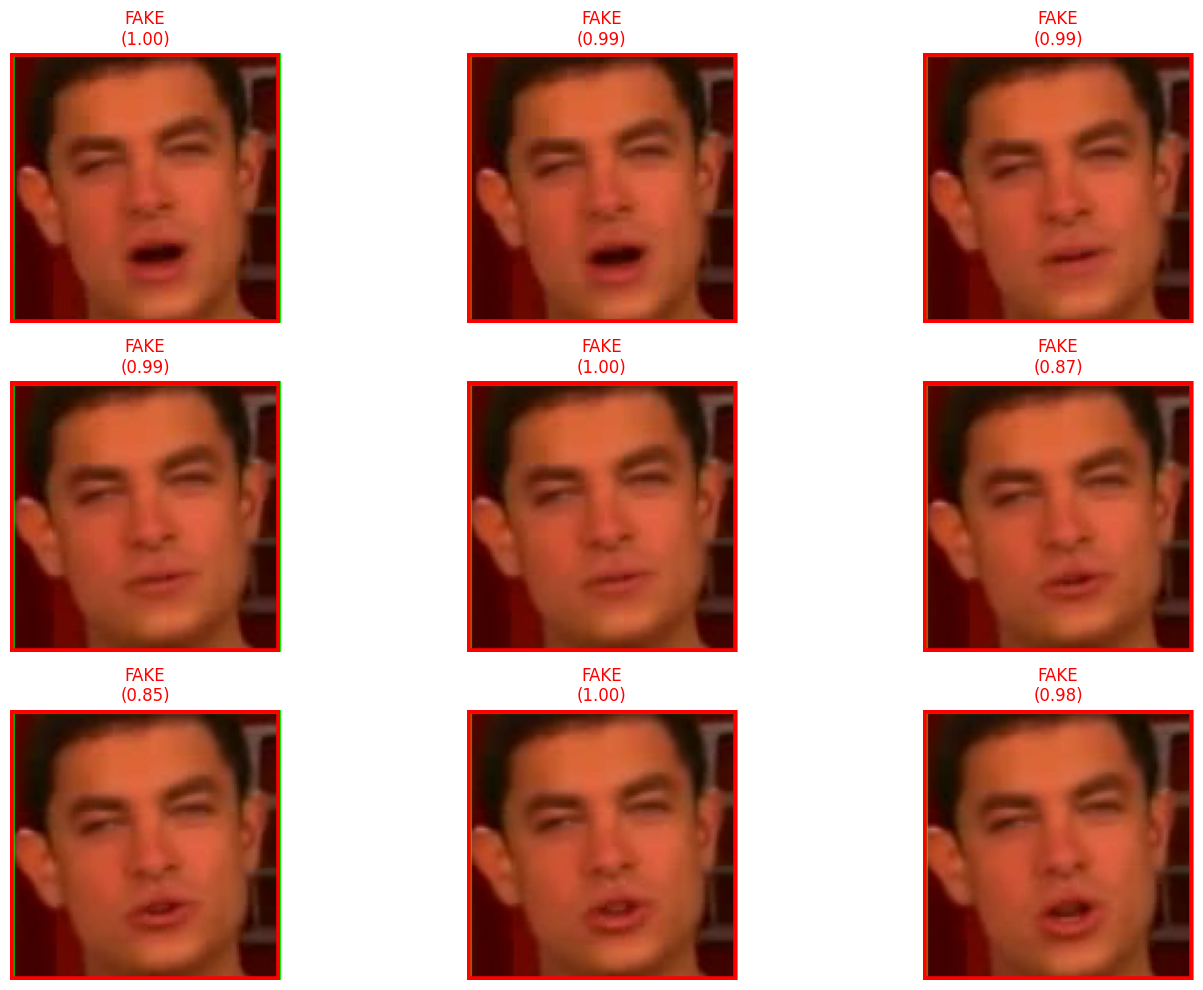

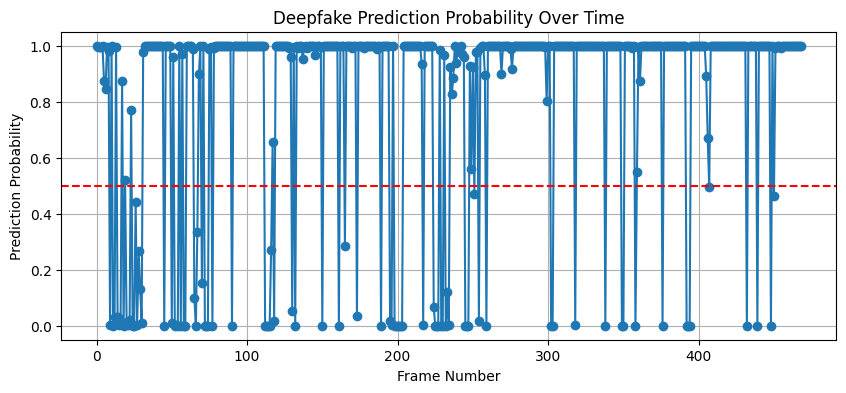

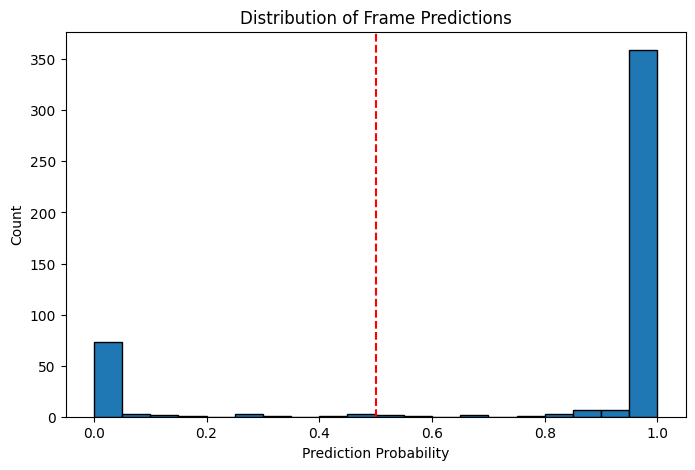


Final Decision: Deepfake (Mean Probability: 0.8125)


In [14]:
# Make prediction with visualizations
video_path = './data/Celeb-synthesis/id0_id16_0000.mp4'
is_deepfake, probability = predict_video(video_path, model)

# Create annotated video
create_annotated_video(video_path, 'annotated_output_fake.mp4', model)

print(f"\nFinal Decision: {'Deepfake' if is_deepfake else 'Real'} "
      f"(Mean Probability: {probability:.4f})")

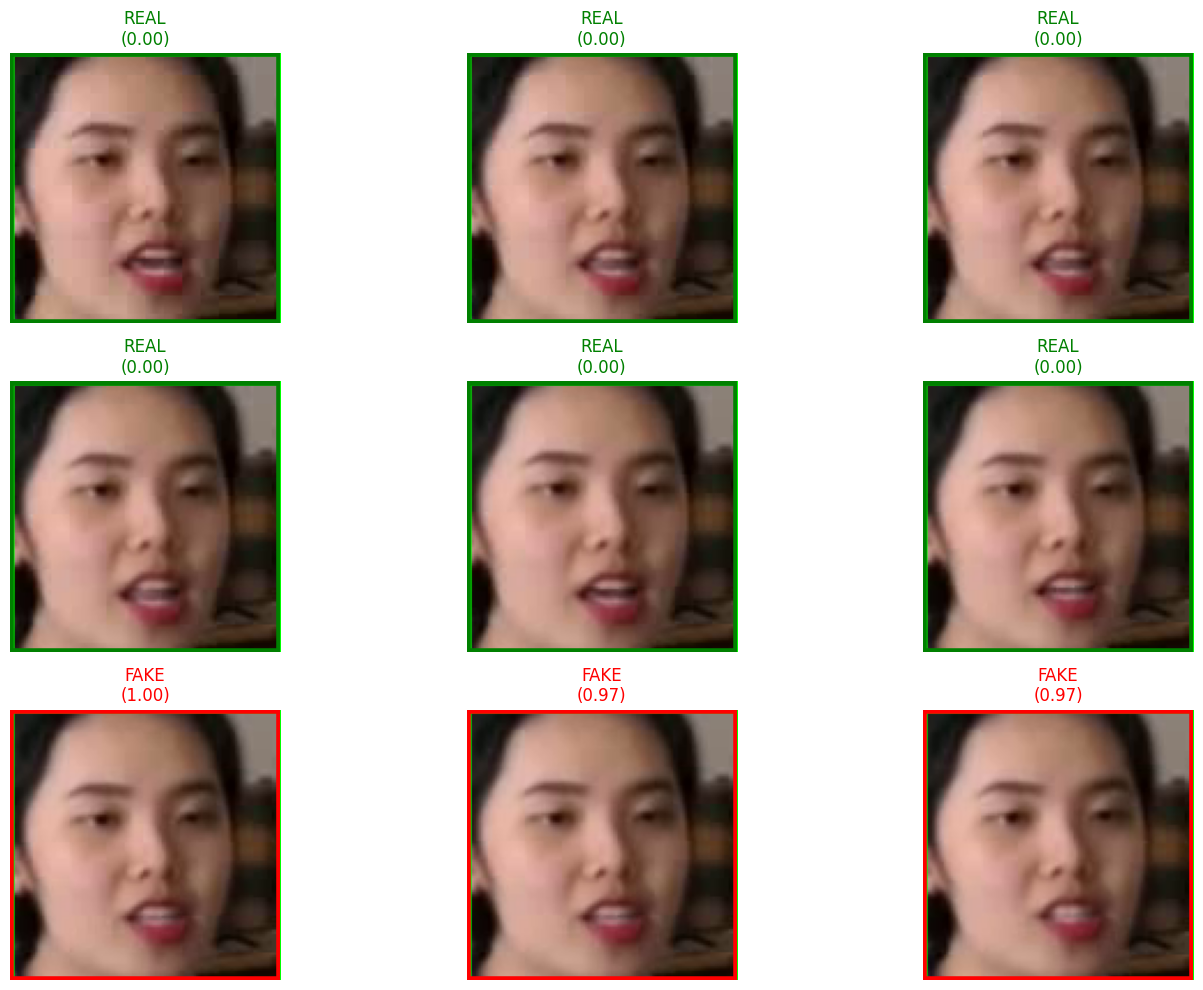

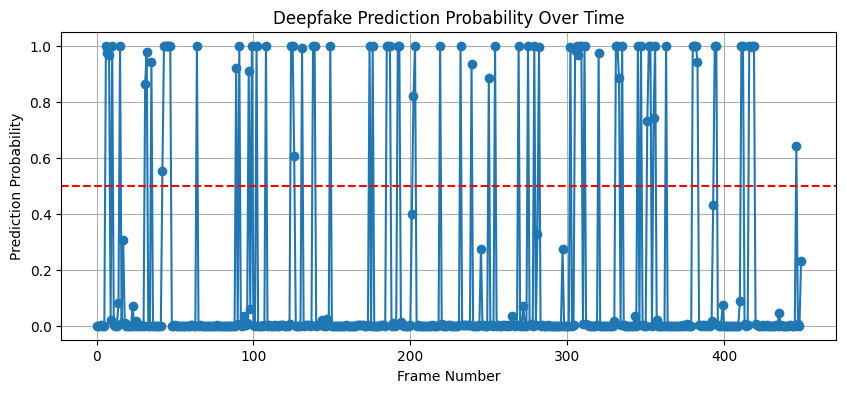

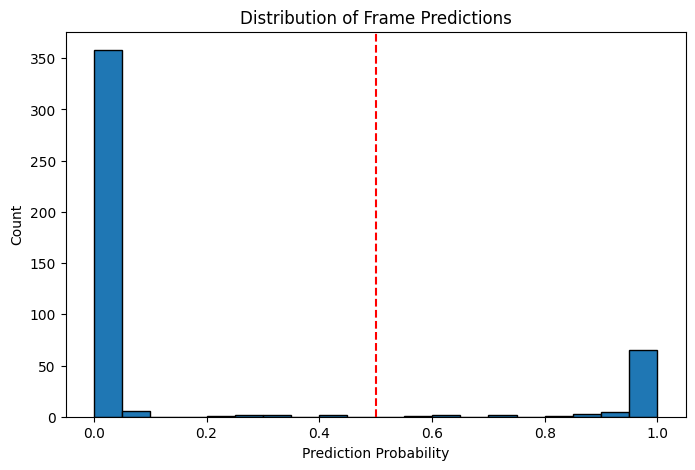


Final Decision: Real (Mean Probability: 0.1767)


In [15]:
video_path = './data/YouTube-real/00000.mp4'
is_deepfake, probability = predict_video(video_path, model)

# Create annotated video
create_annotated_video(video_path, 'annotated_output_real.mp4', model)

print(f"\nFinal Decision: {'Deepfake' if is_deepfake else 'Real'} "
      f"(Mean Probability: {probability:.4f})")

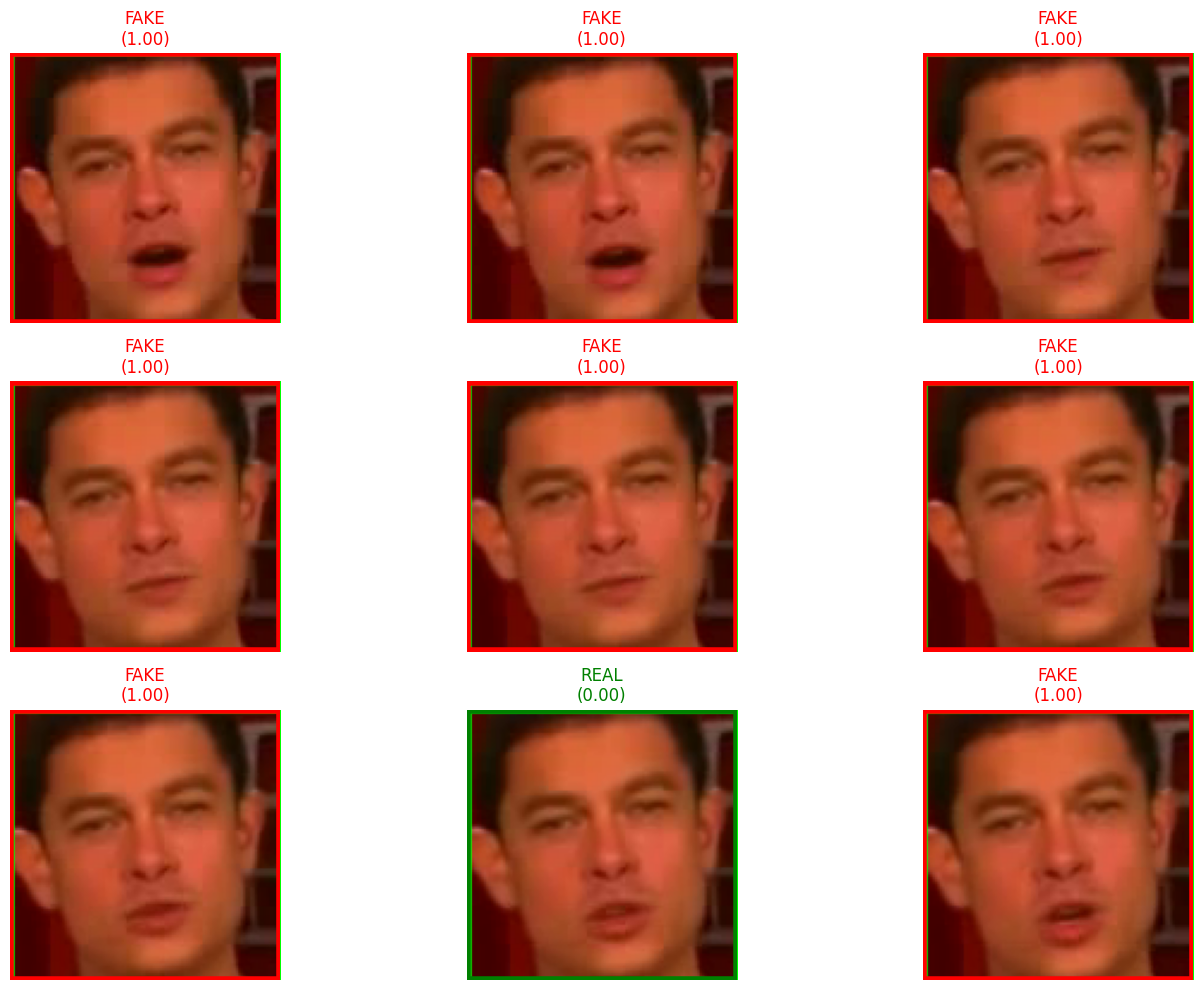

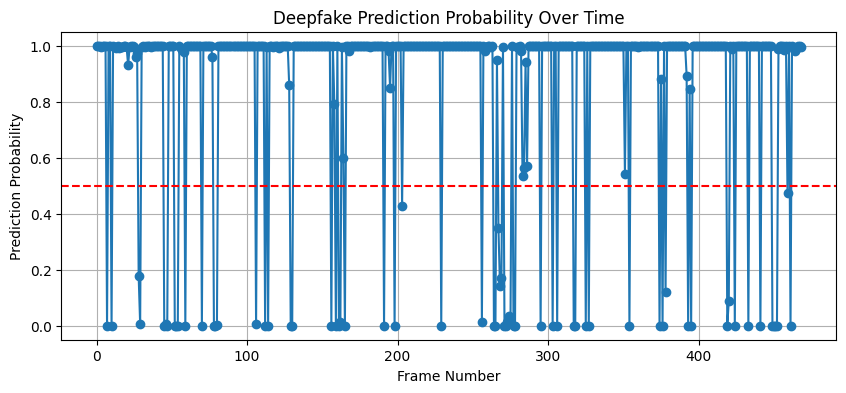

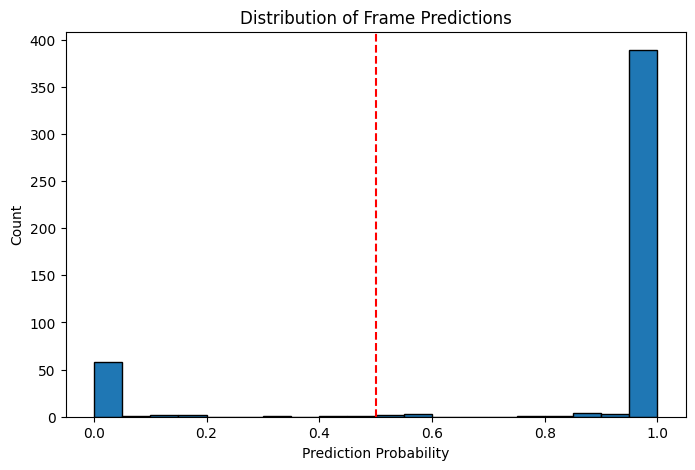


Final Decision: Deepfake (Mean Probability: 0.8556)


In [16]:
# Make prediction with visualizations
video_path = './data/Celeb-synthesis/id0_id1_0000.mp4'
is_deepfake, probability = predict_video(video_path, model)

# Create annotated video
create_annotated_video(video_path, 'annotated_output_fake1.mp4', model)

print(f"\nFinal Decision: {'Deepfake' if is_deepfake else 'Real'} "
      f"(Mean Probability: {probability:.4f})")

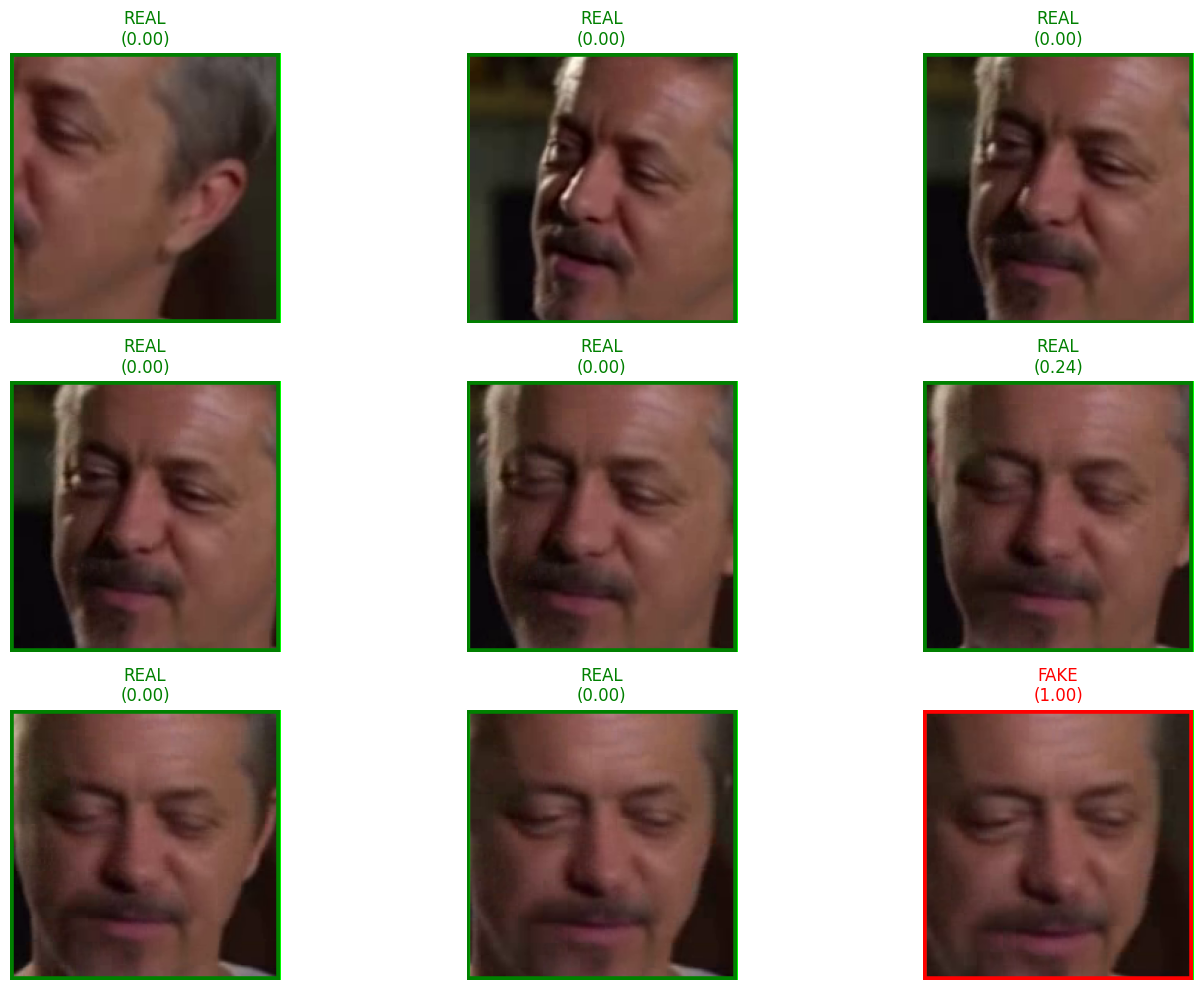

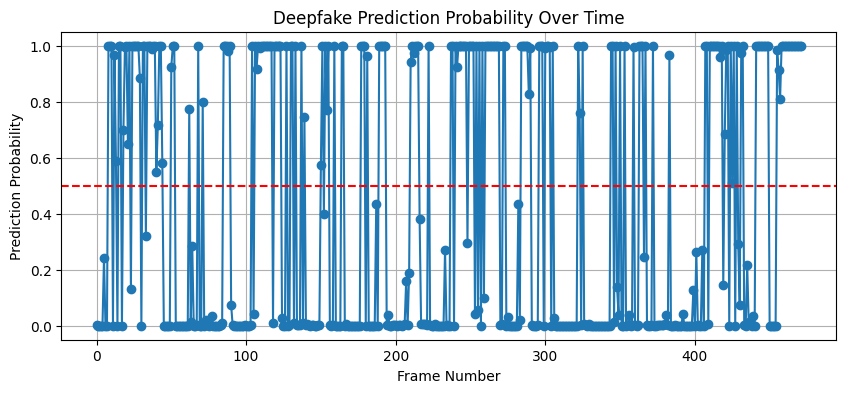

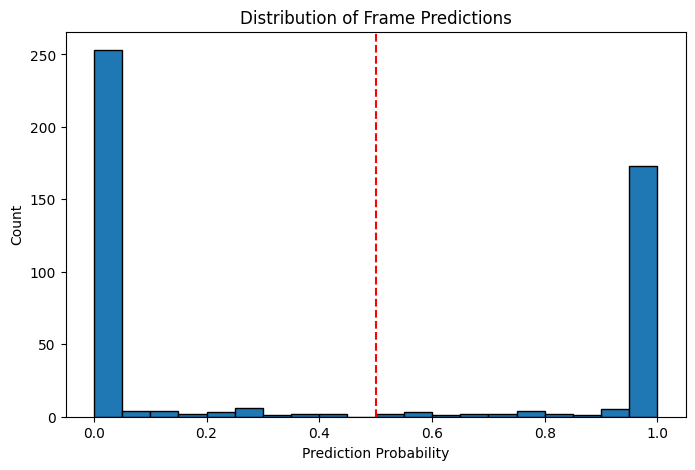


Final Decision: Real (Mean Probability: 0.4142)


In [18]:
video_path = './data/YouTube-real/00002.mp4'
is_deepfake, probability = predict_video(video_path, model)

# Create annotated video
create_annotated_video(video_path, 'annotated_output_real1.mp4', model)

print(f"\nFinal Decision: {'Deepfake' if is_deepfake else 'Real'} "
      f"(Mean Probability: {probability:.4f})")

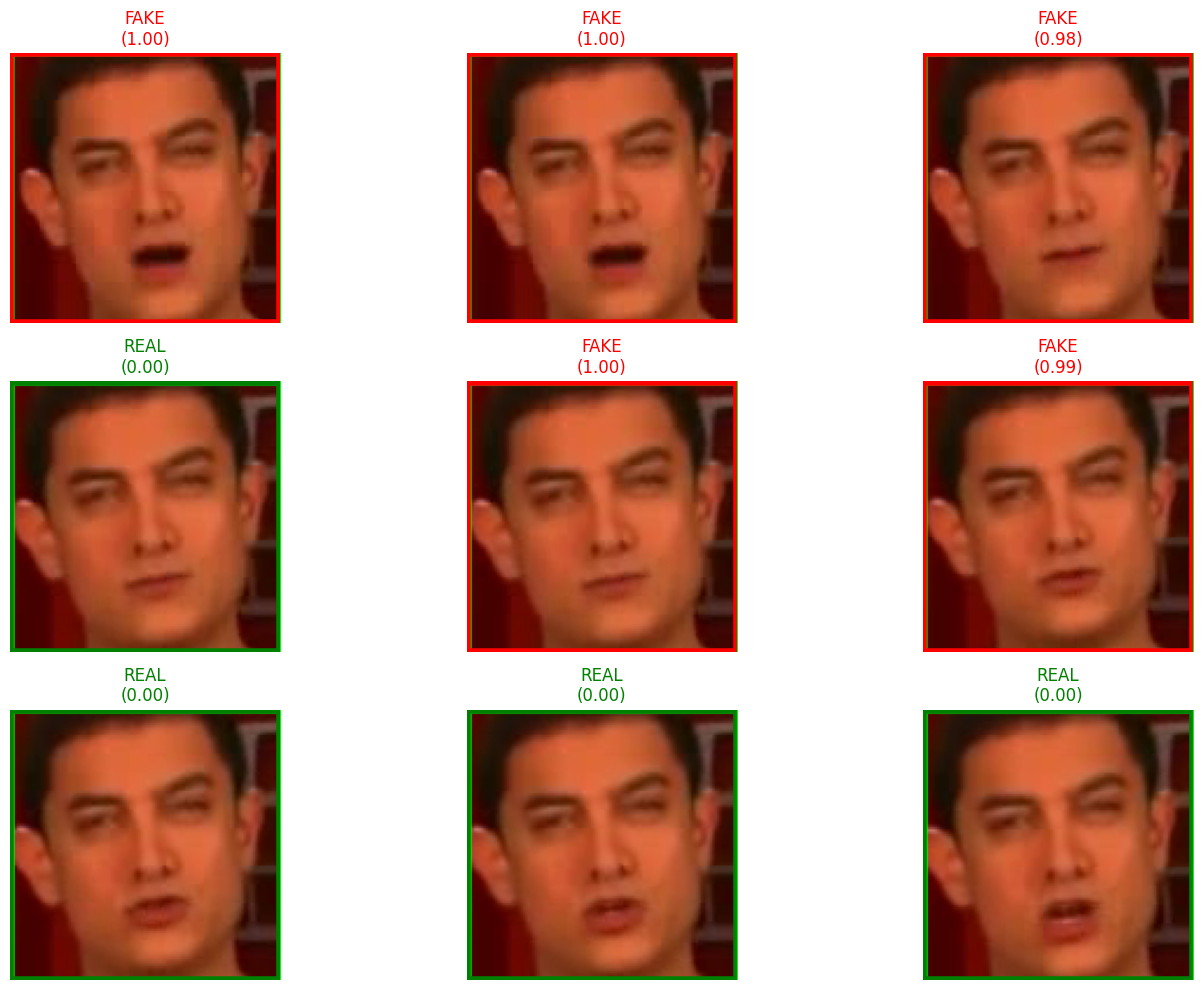

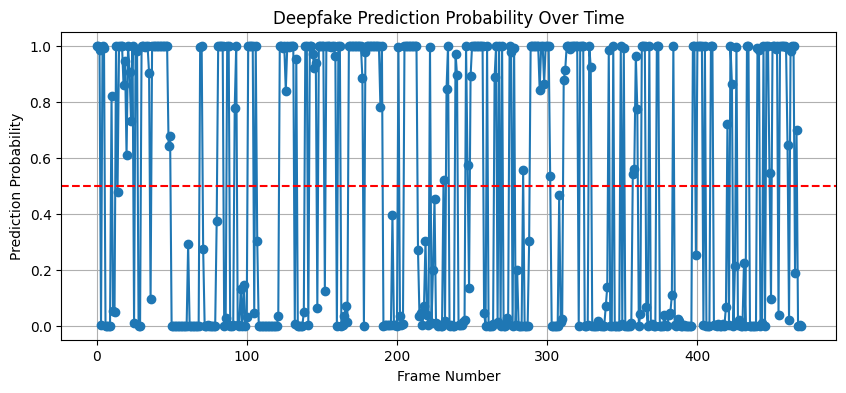

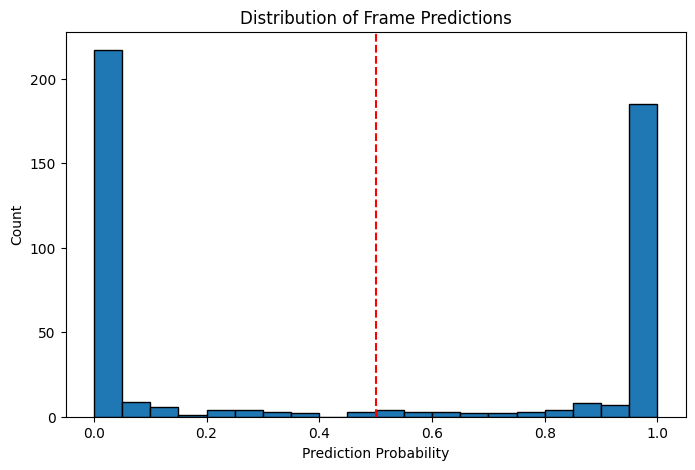


Final Decision: Real (Mean Probability: 0.4680)


In [19]:
video_path = './data/Celeb-real/id0_0000.mp4'
is_deepfake, probability = predict_video(video_path, model)

# Create annotated video
create_annotated_video(video_path, 'annotated_output_real.mp4', model)

print(f"\nFinal Decision: {'Deepfake' if is_deepfake else 'Real'} "
      f"(Mean Probability: {probability:.4f})")